In [15]:
import pandas as pd
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [16]:
#input data
def input_data(folder):
    cv = pd.read_csv(folder+'/' + folder + '_video_result.csv')
    cv['pupil'] = pd.to_numeric(cv['pupil'], errors='coerce')
    cv['pupil'] /= 3
    cv['ratio'] = pd.to_numeric(cv['ratio'], errors='coerce')
    cv['x'] = pd.to_numeric(cv['x'], errors='coerce')
    cv['y'] = pd.to_numeric(cv['y'], errors='coerce')
    cv['ts'] = pd.to_numeric(cv['ts'], errors='coerce')
    cv['ts'] = np.around(cv['ts'], decimals=0)
    #seperate by steps
    cv = cv[cv['pupil'] > 0] #remove zeros
    
    s30_cv = cv[cv['step'] == 30]
    s31_cv = cv[cv['step'] == 31]
    s32_cv = cv[cv['step'] == 32]
    
    print(cv.head(5), '\n')
    
    return cv, s30_cv, s31_cv, s32_cv

def input_eve_data(folder, step, step_num):
    left_pupil_db = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['left_p']['data'])) #in mm
    left_pupil_valid =  pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['left_p']['validity']))
    
    right_pupil_db = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['right_p']['data']))
    right_pupil_valid =  pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['right_p']['validity']))
    
#     px_2_mm = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['pixels_per_millimeter']))
    gaze_right = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['right_o']['data']))
    gaze_left = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['left_o']['data']))
    gaze_left = gaze_left.rename(columns={0: 'x', 1: 'y', 2: 'z'})
    gaze_right = gaze_right.rename(columns={0: 'x', 1: 'y', 2: 'z'})
    
    mm_per_px = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['millimeters_per_pixel']))
    mm_per_px = mm_per_px[0][0]
    
    #normalise input data
    #eve db
    #convert mm into pixels
    left_pupil_db /= mm_per_px
    left_pupil_db /= 2
    right_pupil_db /= mm_per_px
    right_pupil_db /= 2
    
    #insert the timestamp information for the eve data
    ts_eve = attach_ts(step_num, folder)
    left_pupil_db['ts'] = ts_eve
    
    # integrate into one dataframe with the coordinate
    left_pupil_db['x'] = gaze_left['x']
    left_pupil_db['y'] = gaze_left['y']
    left_pupil_db['validity'] = left_pupil_valid

    right_pupil_db['ts'] = ts_eve
    right_pupil_db['x'] = gaze_right['x']
    right_pupil_db['y'] = gaze_right['y']
    right_pupil_db['validity'] = right_pupil_valid

    left_pupil_db = left_pupil_db.rename(columns={0: 'pupil'})
    right_pupil_db = right_pupil_db.rename(columns={0: 'pupil'})
    left_pupil_db = left_pupil_db[left_pupil_db['pupil'] != 0]
    right_pupil_db = right_pupil_db[right_pupil_db['pupil'] != 0]
    
    #almost all the data is valid
    print(left_pupil_db.head(5), '\n')
    return left_pupil_db[left_pupil_db['validity'] == True], right_pupil_db[right_pupil_db['validity'] == True], ts_eve

In [17]:
def attach_ts(stepnum, folder):
    f = open(folder+'/step_' + stepnum +'_webcam_c.timestamps.txt','r')
    ts = []
    for line in f.readlines():
        ts.append(float(line[:-1]))

    start = ts[0]
    for i in range(len(ts)):
        ts[i] -= start
        ts[i] /= 1000000 #from ms to s
        ts[i] = np.around(ts[i], decimals=0)
    return ts


In [18]:
from statsmodels.stats.stattools import medcouple
import math

def get_quartiles(arr):
    arr = [i for i in arr if not np.isnan(i)]
    arr = np.sort(arr)
    mid = int(len(arr)/2)
    if(len(arr)%2 == 0):
        Q1 = np.median(arr[:mid])
        Q3 = np.median(arr[mid:])
    else:
        Q1 = np.median(arr[:mid])
        Q3 = np.median(arr[mid:])
    return Q1,Q3

def adjust_boxplot(values, param, bias=1.5, f=None):
    mc = np.around(medcouple(values), decimals=1)
    print('**medcouple', mc)
    
    if mc == 0: #tukeys method
        q1,q3 = get_quartiles(values)
        iqr = q3 - q1
        lowerLimit = np.around(q1 - bias*iqr, decimals=2)
        upperLimit = np.around(q3 + bias*iqr, decimals=2)
    else:
        q1,q3 = get_quartiles(values)
        iqr = q3 - q1
        if mc > 0:
            lowerLimit = np.around(q1 - bias*math.exp(-3.5*mc)*iqr, decimals=2)
            upperLimit = np.around(q3 + bias*math.exp(4*mc)*iqr, decimals=2)
        else:
            lowerLimit = np.around(q1 - bias*math.exp(-4*mc)*iqr, decimals=2)
            upperLimit = np.around(q3 + bias*math.exp(3.5*mc)*iqr, decimals=2)
        
    print('IQR', iqr, 'lower', lowerLimit, 'Q1', q1, 'Q3', q3, 'upper', upperLimit)
    result = []
    for v in values:
        if v < lowerLimit or v > upperLimit: 
            result.append(0)
        else:
            result.append(v)
            
    remove = np.around(1-(len([i for i in result if i != 0])/len(values)), decimals=2)
    print('remove ratio ', remove, '\n')
    if f is not None:
        f.write('\n remove outlier by param ' + param + ' with bias = ' + str(bias))
        f.write('\n** medcouple = ' + str(mc))
        f.write('\nIQR | LOWER | Q1 | UPPER | Q3: ')
        f.write(str(iqr) + ' | ' + str(lowerLimit) + ' | ' + str(q1) + ' | ' + str(q3) + ' | ' + str(upperLimit))
        f.write('\nremote ratio = ' + str(remove))
    return result

def remove_outliers(df, param, bias=1.5, f=None): 
    ad_value = adjust_boxplot(list(df[param]), param, bias, f)
    df[param] = ad_value
    df = df[df[param] != 0]
    
    return df


In [19]:
#merge function for cv db
def merge_both_side(ts, df_left, df_right):
    data = []
    print('ts len', len(ts))
    print( len([i for i in df_left['pupil'] if not np.isnan(i) and i != 0]))
    print( len([i for i in df_right['pupil'] if not np.isnan(i) and i != 0]))
    
    for t in ts:
        left_series = df_left[df_left['ts'] == t]
        right_series = df_right[df_right['ts'] == t]
        
        if len(left_series) != 0:
            left = list(left_series['pupil'])[0]
            y_left = list(left_series['y'])[0]
            x_left = list(left_series['x'])[0]
        else:
            left, y_left, x_left = np.nan, np.nan, np.nan
        
        if len(right_series) != 0:
            right = list(right_series['pupil'])[0]
            y_right = list(right_series['y'])[0]
            x_right = list(right_series['x'])[0]
        else:
            right, y_right, x_right = np.nan, np.nan, np.nan
        
        if not np.isnan(left) and not np.isnan(right):
            data.append([t, np.mean([left, right])])
        elif not np.isnan(right):
            data.append([t, right])
        elif not np.isnan(left):
            data.append([t, left])
        else:
            data.append([t, np.nan])
        
    print( len([i for i in data if not np.isnan(i[1])]))
    df = pd.DataFrame(data, columns=['ts', 'pupil'])
    df['pcps'] = df['pupil'].pct_change()
    df = df[df['pupil'] != np.nan]
    return df


In [20]:
### normalise into 1sec
def nor_1000(df, sec=1, overlap=0):
    video_length = np.around(list(df['ts'])[-1]/1000, decimals=0)
    print('video length', video_length)
    rang = sec-overlap
    print(rang)
    times = np.arange(0, video_length*1000, (1000*rang)) #interval
    start = 0
    data = []
    for t in times[1:]:
        rows = df[ (df['ts'] >= start) & (df['ts'] <= t)]
        values = sorted([i for i in rows['pupil'] if i != 0])
#         if len(values) >= 3:
#             data.append([start, np.around(np.nanmean(values[1:-1]), decimals=3)]) #ignore the maximum and minimum
#         else:
        data.append([start, np.around(np.nanmean(values), decimals=3)])
        start = t

    return pd.DataFrame(data, columns=['ts', 'pupil'])

In [21]:
def plot_in_interval(cv, eve, f, fname, title, sec=1, overlap=0):
    print(sec, ' SEC Timeframe')
    f.write('\n---' + str(sec) + ' SEC timeframe --- with overlap ' + str(overlap) )
    cv_new = nor_1000(cv, sec, overlap)
    eve_new = nor_1000(eve, sec, overlap)

    cv_new['pcps'] = cv_new['pupil'].pct_change()
    eve_new['pcps'] = eve_new['pupil'].pct_change()

#     cv_new.head(5)
#     eve_new.head(5)
#     print('\n')
    #plot
    y_cv = list(cv_new['pupil'])
    y_db = list(eve_new['pupil'])
    pcps_cv = list(cv_new['pcps'])
    pcps_db = list(eve_new['pcps'])
    
    _, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 6), sharex=True)
    ax1.set_title(title)
    ax1.plot(pcps_cv, label='cv pcps')
    ax1.plot(pcps_db, label='eve pcps')
    ax2.plot(y_cv, label='cv pupil')
    ax2.plot(y_db, label='eve pupil')
    ax3.plot(abs(np.array(y_db) - np.array(y_cv)), label='pupil pixels difference')
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    ax3.legend(loc='best')
    plt.savefig(fname=fname, dpi=100, bbox_inches="tight")
    plt.show()
    
    #### write to log
    print(len(y_db), len(y_cv))
    f.write('length of results: ')
    f.write(str(len(y_db)))
    f.write(' eve <- | -> opencv ')
    f.write(str(len(y_cv)))
    
    print('in terms of pcps')
    print('\neve pcps mean| max| min:', np.nanmean(pcps_db), np.nanmax(pcps_db), np.nanmin(pcps_db))
    f.write('\neve results\n')
    f.write('mean | max | min ')
    f.write(str(np.nanmean(pcps_db)) + ' | ' + str(np.nanmax(pcps_db)) + ' | ' + str(np.nanmin(pcps_db)))
    print('cv mean| max| min:', np.nanmean(pcps_cv), np.nanmax(pcps_cv), np.nanmin(pcps_cv))
    f.write('\nopencv results\n')
    f.write('mean | max | min ')
    f.write(str(np.nanmean(pcps_cv)) + ' | ' + str(np.nanmax(pcps_cv)) + ' | ' + str(np.nanmin(pcps_cv)))
    print('cv sd', np.nanstd(pcps_cv))
    print('eve sd', np.nanstd(pcps_db))
    f.write('\nstandard deviation ')
    f.write(str(np.nanstd(pcps_db)))
    f.write(' eve <- | -> opencv ')
    f.write(str(np.nanstd(pcps_cv)))
    
    print('in terms of pupil radius')
    diff = abs(np.array(y_db) - np.array(y_cv))
    diff = np.around(diff, decimals=3)
    print('diff between two mean| max| min:', np.nanmean(diff), np.nanmax(diff), np.nanmin(diff))
    f.write('\ndiffence between eve and cv pupils')
    f.write(str(diff))
    f.write('\n mean | max | min ')
    f.write(str(np.nanmean(diff)) + ' | ' + str(np.nanmax(diff)) + ' | ' + str(np.nanmin(diff)))
    print('diff sd', np.nanstd(diff))
    f.write('\ndiff sd')
    f.write(str(np.nanstd(diff)))
    
    print('\neve mean| max| min:', np.nanmean(y_db), np.nanmax(y_db), np.nanmin(y_db))
    f.write('\neve results\n')
    f.write('mean | max | min ')
    f.write(str(np.nanmean(y_db)) + ' | ' + str(np.nanmax(y_db)) + ' | ' + str(np.nanmin(y_db)))
    print('cv mean| max| min:', np.nanmean(y_cv), np.nanmax(y_cv), np.nanmin(y_cv))
    f.write('\nopencv results\n')
    f.write('mean | max | min ')
    f.write(str(np.nanmean(y_cv)) + ' | ' + str(np.nanmax(y_cv)) + ' | ' + str(np.nanmin(y_cv)))
    print('cv sd', np.nanstd(y_cv))
    print('eve sd', np.nanstd(y_db))
    f.write('\nstandard deviation ')
    f.write(str(np.nanstd(y_db)))
    f.write(' eve <- | -> opencv ')
    f.write(str(np.nanstd(y_cv)))

In [22]:
def normalize_data(data):
    maxim = np.max(data)
    minim = np.min(data)
    scaled = np.array([(x - minim) / (maxim - minim) for x in data])
    return scaled

In [23]:
def run(step_num, step_cv_df, folder):
    step_num = str(step_num)
    step = 'step_' + step_num
    save_file = folder+'/'+step
    suffix = 'video'
    f = open(save_file+'_log_'+suffix+ '.txt', 'w')
    f.write('\n\n step ' + step_num + '---------- ')
    ######################## input data ################################
    ts_cv = []
    for t in list(step_cv_df['ts']): #the whole ts list before removing any values
        if t not in ts_cv:
            ts_cv.append(t)
    
    #input eve data
    left_pupil_db, right_pupil_db, ts_eve = input_eve_data(folder, step, step_num)
    
    #### plot titles
    title_distrib = folder + '_' + step_num +'_Frequency_Histogram_(bin_30)-'+suffix
    title_scatter_e = folder + '_' + step_num +'_eve(x,y)_scatter-'+suffix
    title_scatter_c = folder + '_' + step_num +'_cv(x,y)_scatter-'+suffix
    title_scatter_p = folder + '_' + step_num +'_pupil_scatter-'+suffix

    
    ## distribution visualize
    plt.hist(list(left_pupil_db['pupil']) + list(right_pupil_db['pupil']), bins=30, label='eve')
    plt.hist(list(step_cv_df['pupil']), bins=30, label='cv')
    plt.gca().set(title=title_distrib , ylabel='Frequency')
    plt.legend(loc='best')
    plt.savefig(save_file+title_distrib+'.png', dpi=100, bbox_inches="tight")
    plt.grid()
    
    ######################## Clean data ################################
    #clean cv data
    before_size = len(list(step_cv_df['pupil']))
    step_cv_df = remove_outliers(step_cv_df, 'pupil', f=f)
    step_cv_df = remove_outliers(step_cv_df, 'y', 3, f=f)
    step_cv_df = remove_outliers(step_cv_df, 'x', 3, f=f)
#     step_cv_df = remove_outliers(step_cv_df, 'pupil', f=f)
        
    f.write('\nafter clean cv data, total remove ratio: ' + str(np.around(1-(len(list(step_cv_df['pupil']))/before_size), decimals=2)))
    print('** after clean cv data, remove ratio', 1-(len(list(step_cv_df['pupil']))/before_size), '\n')
#     print('two eyes distances sd', np.nanstd([i for i in step_cv_df['d2'] if i != -1]))
    
    changes_cv_left = step_cv_df[step_cv_df['side'] == 'L'] #select individual side
    changes_cv_right = step_cv_df[step_cv_df['side'] == 'R']
    
    #clean eve data
    left_pupil_db = remove_outliers(left_pupil_db, 'pupil', f=f)
    right_pupil_db = remove_outliers(right_pupil_db, 'pupil', f=f)
    
    ##################### ALL ########################
    #plot eve coordinate
    _, (ax1, ax2) = plt.subplots(2, figsize=(15, 6))
    ax1.scatter(x=list(left_pupil_db['ts']), y=list(left_pupil_db['x']), label='left x', s=5)
    ax1.scatter(x=list(right_pupil_db['ts']), y=list(right_pupil_db['x']+60), label='right x', s=5)
    ax2.scatter(x=list(left_pupil_db['ts']), y=list(left_pupil_db['y']), label='left y', s=5)
    ax2.scatter(x=list(right_pupil_db['ts']), y=list(right_pupil_db['y']), label='right y', s=5)
    ax2.grid()
    ax1.set_title(title_scatter_e)
    ax2.legend(loc='best')
    ax1.grid()
    ax1.legend(loc='best')
    plt.savefig(save_file+title_scatter_e+'.png', dpi=100, bbox_inches="tight")
    plt.show()
    
    #plot cv coordinate
    _, (ax1, ax2) = plt.subplots(2, figsize=(15, 6))
    ax1.scatter(x=changes_cv_left['ts'], y=list(changes_cv_left['x']), label='left x', s=5)
    ax1.scatter(x=changes_cv_right['ts'], y=list(changes_cv_right['x']), label='right x', s=5)
    ax2.scatter(x=changes_cv_left['ts'], y=list(changes_cv_left['y']*-1), label='left y', s=5)
    ax2.scatter(x=changes_cv_right['ts'], y=list(changes_cv_right['y']*-1), label='right y', s=5)
    ax2.grid()
    ax1.set_title(title_scatter_c)
    ax2.legend(loc='best')
    ax1.grid()
    ax1.legend(loc='best')
    plt.savefig(save_file+title_scatter_c+'.png', dpi=100, bbox_inches="tight")
    plt.show()

    #merge both side
    print('cv db')
    cv = merge_both_side(ts_cv, changes_cv_left, changes_cv_right)
    cv['pupil'] = normalize_data(cv['pupil'])
    print('\neve db')
    eve = merge_both_side(ts_eve, left_pupil_db, right_pupil_db) 
    eve['pupil'] = normalize_data(eve['pupil'])
    
    y_db = list(eve['pupil'])
    y_cv = list(cv['pupil'])
    video_length = np.around(list(eve['ts'])[-1]/1000, decimals=0)
    freq_eve = np.around(len(y_db)/video_length, decimals=0)
    freq_cv = np.around(len(y_cv)/video_length, decimals=0)
    
    f.write('\nEVE ' + str(freq_eve) + ' hz | CV ' + str(freq_cv) + ' hz')
    print('EVE ' + str(freq_eve) + ' hz | CV ' + str(freq_cv) + ' hz')
        
    plt.figure(figsize=(15, 6))
    plt.title(title_scatter_p)
    plt.scatter(x=eve['ts'], y=y_db, label='eve', s=5)
    plt.scatter(x=cv['ts'], y=y_cv, label='cv', s=5)
    plt.ylim(bottom=0, top=4)
    plt.grid()
    plt.legend(loc='best')
    plt.savefig(fname=save_file+title_scatter_p+'.png', dpi=100, bbox_inches="tight")
    plt.show()
    
    for i in range(1, 5):
        title = folder + '_' + step_num +'_' + str(i) + '_sec_(EVE_'+ str(freq_eve) + 'Hz|CV_' + str(freq_cv) + 'Hz)-'+suffix
        if i > 2:
            title += 'overlap_' + str(1)
        fname = save_file+'_'+str(i)+'sec_'+suffix+'.png'
        if i > 2:
            plot_in_interval(cv, eve, f, fname, title, i, 1)
        else:
            plot_in_interval(cv, eve, f, fname, title, i)
            
    f.close()

In [24]:
# cv_36, s30_cv36, s31_cv36, s32_cv36 = input_data('train36')
# run('30', s30_cv36, 'train36')
# run('31', s31_cv36, 'train36')
# run('32', s32_cv36, 'train36')

   step     ts      x     y     pupil  ratio    sim side     d2
0    30    0.0  142.0  50.0  5.500000   0.33  16.75    R  -1.00
1    30   67.0  148.0  45.5  5.250000   0.31  12.87    R  -1.00
2    30  133.0  147.0  50.0  5.166667   0.31  14.95    R  -1.00
3    30  167.0  150.5  38.0  5.250000   0.33   1.71    L  12.85
4    30  200.0  152.0  41.0  5.333333   0.31   1.61    L  -1.00 

      pupil     ts          x         y  validity
0  4.510245    0.0  62.605919 -2.692040      True
1  4.498950   36.0  62.650768 -2.693703      True
2  4.495349   68.0  62.621803 -2.478320      True
3  4.490366  100.0  62.499352 -2.679098      True
4  4.489487  132.0  62.546566 -2.715477      True 

**medcouple 0.0
IQR 0.5 lower 4.5 Q1 5.25 Q3 5.75 upper 6.5
remove ratio  0.09 

**medcouple 0.1
IQR 7.5 lower 18.14 Q1 34.0 Q3 41.5 upper 75.07
remove ratio  0.04 

**medcouple -0.1
IQR 10.0 lower 99.25 Q1 144.0 Q3 154.0 upper 175.14
remove ratio  0.02 

** after clean cv data, remove ratio 0.14423076923076927

C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


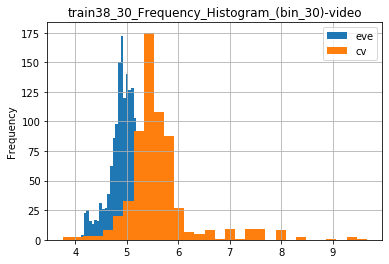

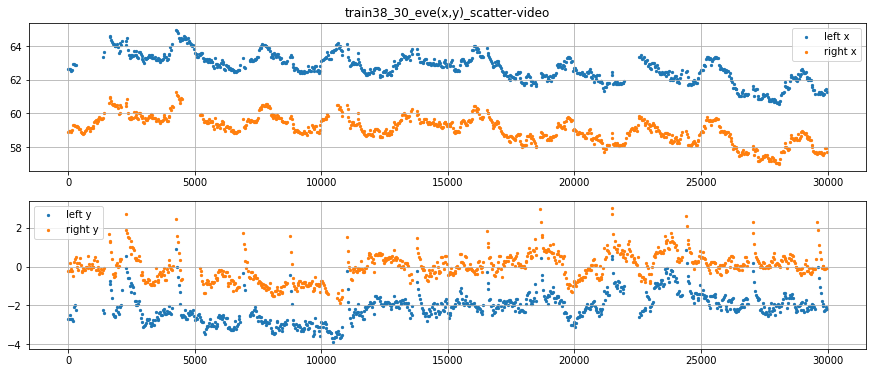

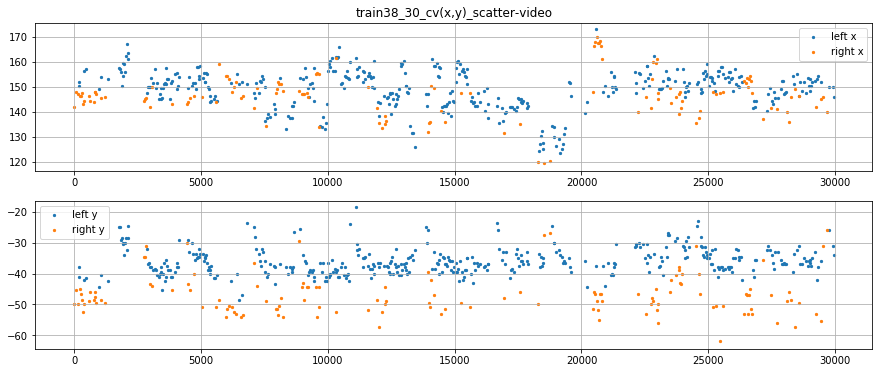

cv db
ts len 607
403
131
534

eve db
ts len 900
801
826
859
EVE 30.0 hz | CV 20.0 hz


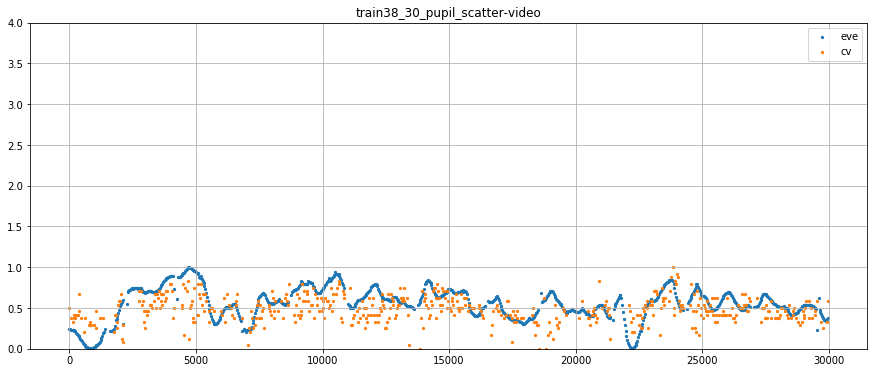

1  SEC Timeframe
video length 30.0
1
video length 30.0
1


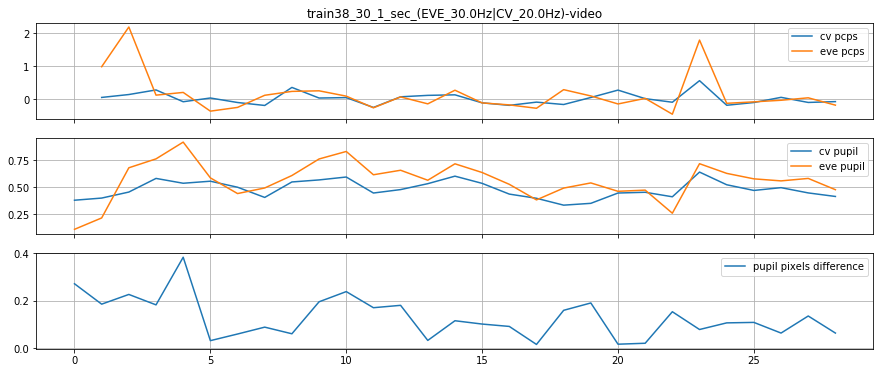

29 29
in terms of pcps

eve pcps mean| max| min: 0.1490071760256133 2.182242990654206 -0.4545454545454545
cv mean| max| min: 0.01792412832338406 0.5596107055961073 -0.2504201680672269
cv sd 0.1809211418115096
eve sd 0.5778562499044355
in terms of pupil radius
diff between two mean| max| min: 0.1280344827586207 0.383 0.015
diff sd 0.08478511692696229

eve mean| max| min: 0.5615517241379311 0.92 0.108
cv mean| max| min: 0.48062068965517246 0.641 0.333
cv sd 0.07842079852248181
eve sd 0.17369187665020125
2  SEC Timeframe
video length 30.0
2
video length 30.0
2


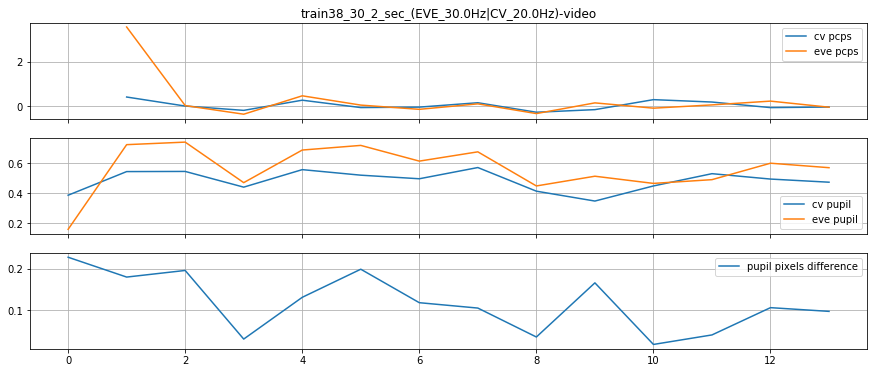

14 14
in terms of pcps

eve pcps mean| max| min: 0.27870383792740366 3.5597484276729556 -0.36522911051212936
cv mean| max| min: 0.034509768067178474 0.4082687338501292 -0.27622377622377625
cv sd 0.19875817079862976
eve sd 0.970420401912726
in terms of pupil radius
diff between two mean| max| min: 0.11771428571428569 0.228 0.017
diff sd 0.06693966213947407

eve mean| max| min: 0.5635714285714285 0.742 0.159
cv mean| max| min: 0.4841428571428571 0.572 0.348
cv sd 0.06580909310037542
eve sd 0.1506375566364104
3  SEC Timeframe
video length 30.0
2
video length 30.0
2


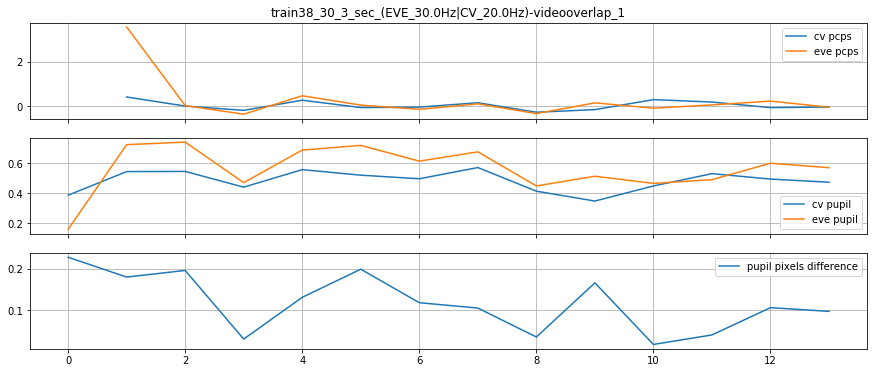

14 14
in terms of pcps

eve pcps mean| max| min: 0.27870383792740366 3.5597484276729556 -0.36522911051212936
cv mean| max| min: 0.034509768067178474 0.4082687338501292 -0.27622377622377625
cv sd 0.19875817079862976
eve sd 0.970420401912726
in terms of pupil radius
diff between two mean| max| min: 0.11771428571428569 0.228 0.017
diff sd 0.06693966213947407

eve mean| max| min: 0.5635714285714285 0.742 0.159
cv mean| max| min: 0.4841428571428571 0.572 0.348
cv sd 0.06580909310037542
eve sd 0.1506375566364104
4  SEC Timeframe
video length 30.0
3
video length 30.0
3


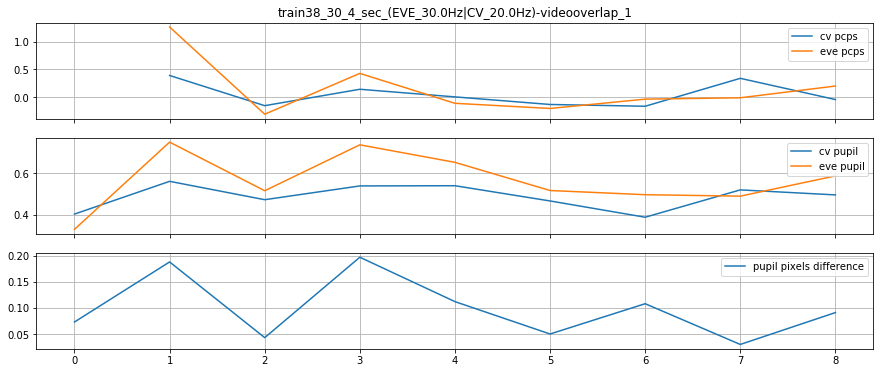

9 9
in terms of pcps

eve pcps mean| max| min: 0.15077327941742905 1.2666666666666666 -0.3114973262032086
cv mean| max| min: 0.04533658446850515 0.38957816377171217 -0.1673819742489271
cv sd 0.20678161210562615
eve sd 0.47423828505821786
in terms of pupil radius
diff between two mean| max| min: 0.09911111111111111 0.197 0.03
diff sd 0.056581199163374334

eve mean| max| min: 0.562888888888889 0.748 0.33
cv mean| max| min: 0.48666666666666664 0.56 0.388
cv sd 0.05700292390161521
eve sd 0.1250994665984227
      pupil     ts          x         y  validity
0  4.786314    0.0  61.798100 -1.087333      True
1  4.758989   36.0  61.818428 -1.086626      True
2  4.737312   68.0  61.629894 -1.152848      True
3  4.718495  100.0  61.707523 -1.097587      True
4  4.710457  136.0  61.574120 -0.961710      True 

**medcouple 0.1
IQR 0.75 lower 4.46 Q1 5.25 Q3 6.0 upper 7.68
remove ratio  0.03 

**medcouple 0.0
IQR 10.0 lower 0.0 Q1 30.0 Q3 40.0 upper 70.0
remove ratio  0.0 

**medcouple -0.1
IQR 13.0

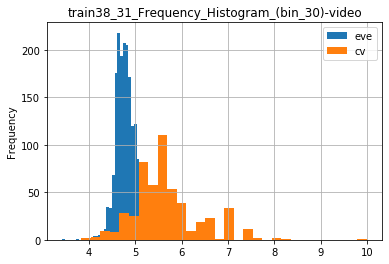

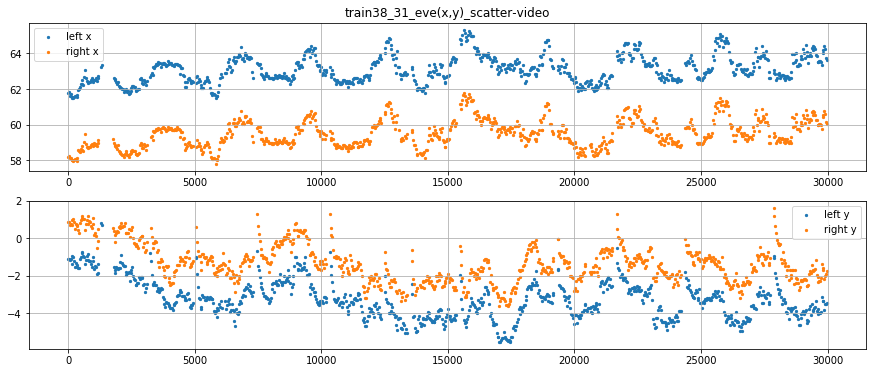

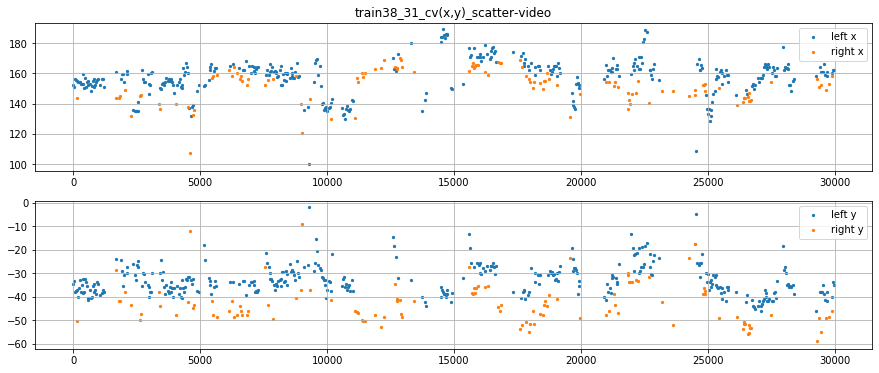

cv db
ts len 507
368
119
487

eve db
ts len 900
841
833
849
EVE 30.0 hz | CV 17.0 hz


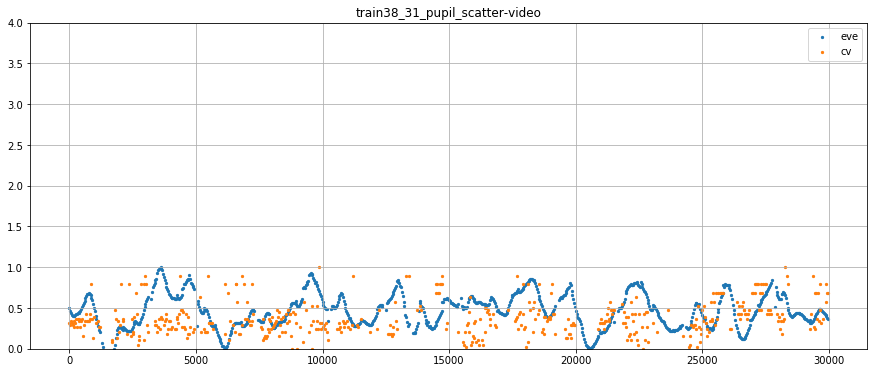

1  SEC Timeframe
video length 30.0
1
video length 30.0
1


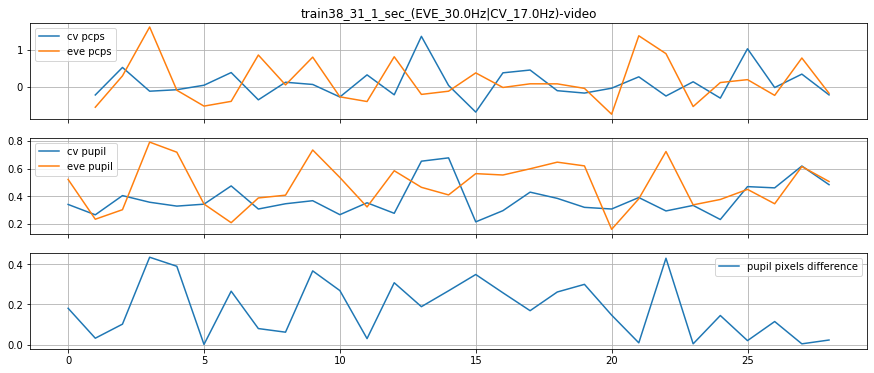

29 29
in terms of pcps

eve pcps mean| max| min: 0.14480927082801512 1.6192052980132452 -0.7415185783521809
cv mean| max| min: 0.08679632977311147 1.3659420289855073 -0.6838995568685378
cv sd 0.4163995371666454
eve sd 0.5871321432268778
in terms of pupil radius
diff between two mean| max| min: 0.17982758620689648 0.435 0.001
diff sd 0.13851977798918683

eve mean| max| min: 0.4768275862068966 0.791 0.16
cv mean| max| min: 0.3785172413793104 0.677 0.214
cv sd 0.1148995425367248
eve sd 0.1635962374083634
2  SEC Timeframe
video length 30.0
2
video length 30.0
2


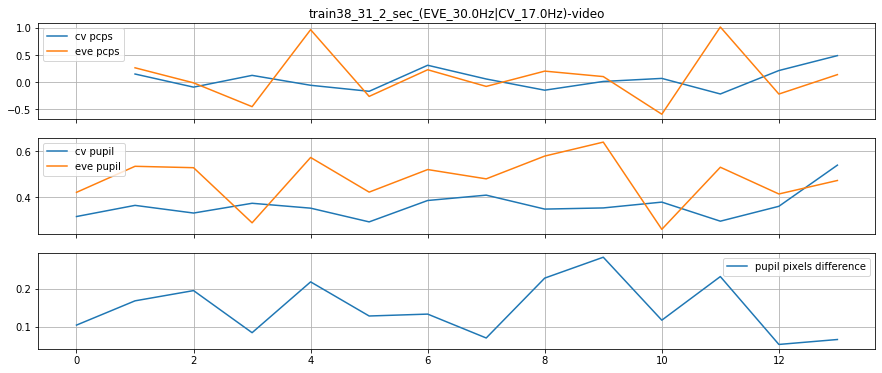

14 14
in terms of pcps

eve pcps mean| max| min: 0.10161741956298494 1.0152091254752853 -0.5877742946708464
cv mean| max| min: 0.05860211860765247 0.4889502762430942 -0.21578947368421053
cv sd 0.1945848805953614
eve sd 0.4550414148364764
in terms of pupil radius
diff between two mean| max| min: 0.1485 0.283 0.053
diff sd 0.07001913003907269

eve mean| max| min: 0.4762142857142857 0.638 0.263
cv mean| max| min: 0.3658571428571428 0.539 0.295
cv sd 0.05743176963376026
eve sd 0.10206732971876147
3  SEC Timeframe
video length 30.0
2
video length 30.0
2


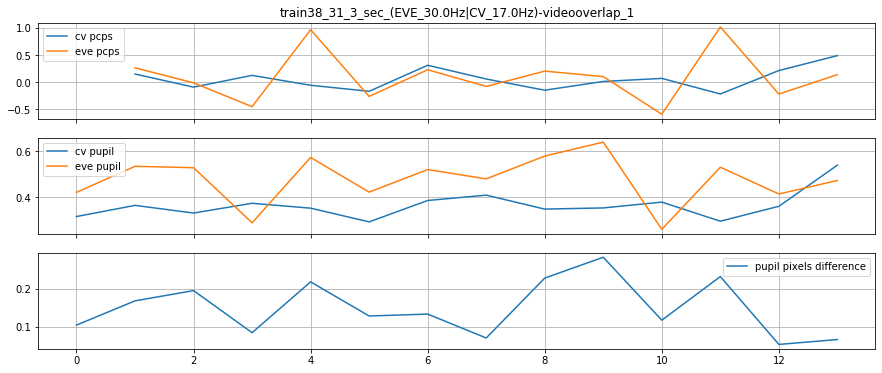

14 14
in terms of pcps

eve pcps mean| max| min: 0.10161741956298494 1.0152091254752853 -0.5877742946708464
cv mean| max| min: 0.05860211860765247 0.4889502762430942 -0.21578947368421053
cv sd 0.1945848805953614
eve sd 0.4550414148364764
in terms of pupil radius
diff between two mean| max| min: 0.1485 0.283 0.053
diff sd 0.07001913003907269

eve mean| max| min: 0.4762142857142857 0.638 0.263
cv mean| max| min: 0.3658571428571428 0.539 0.295
cv sd 0.05743176963376026
eve sd 0.10206732971876147
4  SEC Timeframe
video length 30.0
3
video length 30.0
3


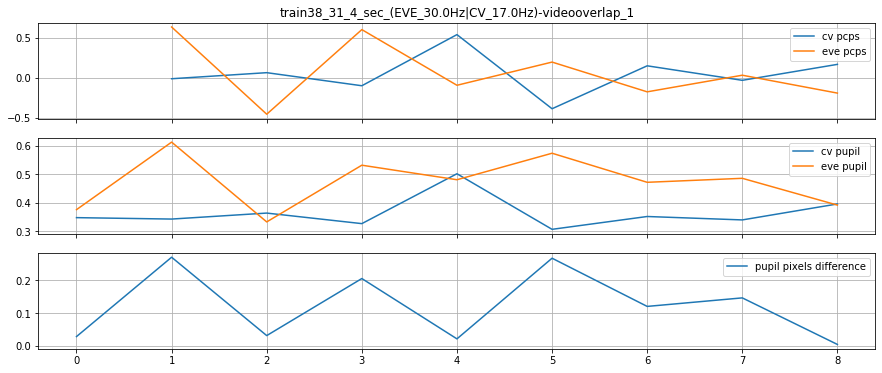

9 9
in terms of pcps

eve pcps mean| max| min: 0.0661856425082004 0.6319999999999999 -0.457516339869281
cv mean| max| min: 0.046339587629164375 0.5368098159509203 -0.3892215568862275
cv sd 0.24671090882815297
eve sd 0.3622632638803975
in terms of pupil radius
diff between two mean| max| min: 0.12133333333333335 0.27 0.004
diff sd 0.10090479561337895

eve mean| max| min: 0.4722222222222222 0.612 0.332
cv mean| max| min: 0.36333333333333334 0.501 0.306
cv sd 0.05385371131335539
eve sd 0.08761377083259327
      pupil     ts          x         y  validity
0  4.443853    0.0  62.786701 -3.160225      True
1  4.476784   32.0  62.692989 -3.306951      True
2  4.510830   68.0  62.560799 -3.023363      True
3  4.535725  100.0  62.602066 -2.711771      True
4  4.562288  132.0  62.858864 -2.571647      True 

**medcouple 0.3
IQR 0.5 lower 4.9 Q1 5.166666666666667 Q3 5.666666666666667 upper 8.16
remove ratio  0.06 

**medcouple 0.0
IQR 11.0 lower -1.0 Q1 32.0 Q3 43.0 upper 76.0
remove ratio  0.01 

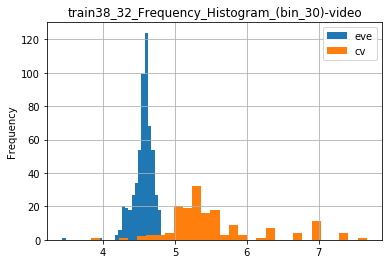

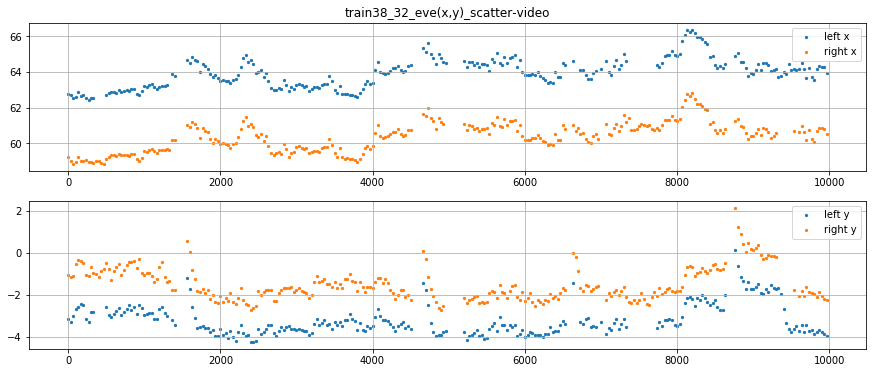

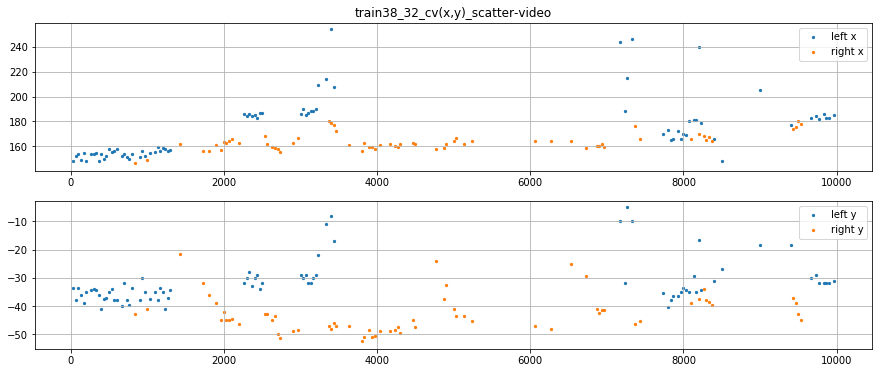

cv db
ts len 155
80
64
141

eve db
ts len 300
261
271
280
EVE 30.0 hz | CV 16.0 hz


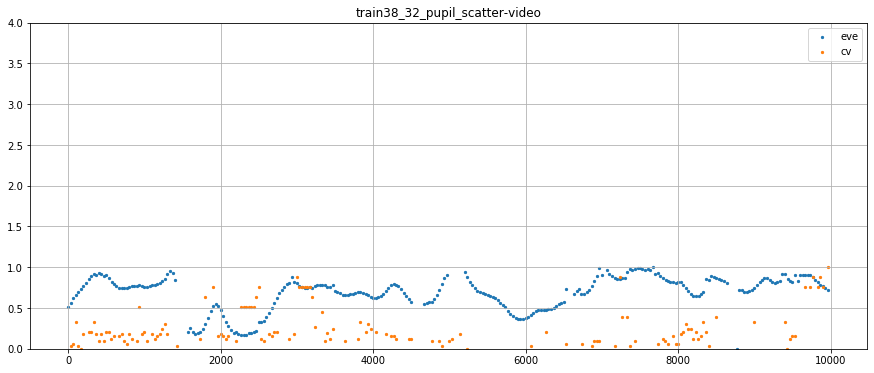

1  SEC Timeframe
video length 10.0
1
video length 10.0
1


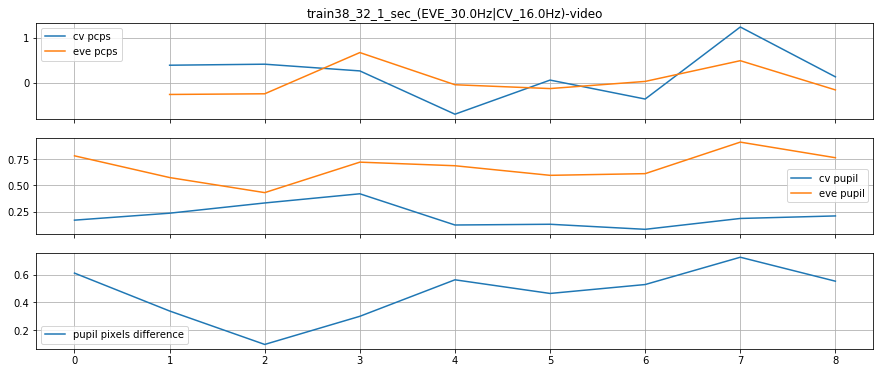

9 9
in terms of pcps

eve pcps mean| max| min: 0.04138024638429126 0.6705336426914152 -0.26410256410256416
cv mean| max| min: 0.17697338905231452 1.2409638554216866 -0.7047619047619047
cv sd 0.5394600345170716
eve sd 0.3267659375730902
in terms of pupil radius
diff between two mean| max| min: 0.464 0.724 0.098
diff sd 0.17860197833917368

eve mean| max| min: 0.6743333333333335 0.91 0.431
cv mean| max| min: 0.21033333333333334 0.42 0.083
cv sd 0.10102034998509514
eve sd 0.13173795538450145
2  SEC Timeframe
video length 10.0
2
video length 10.0
2


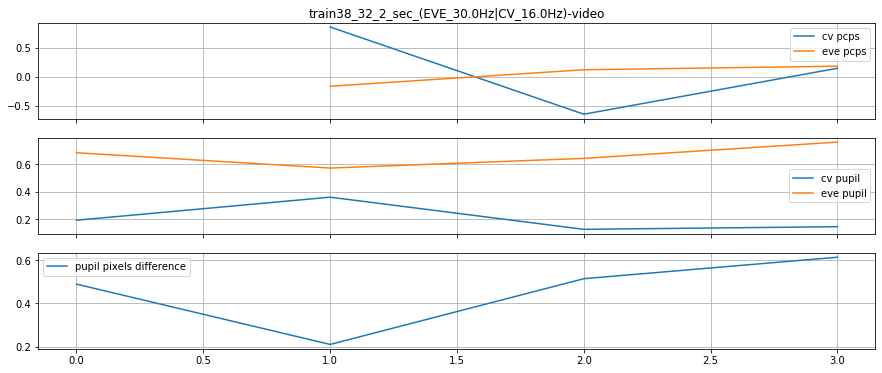

4 4
in terms of pcps

eve pcps mean| max| min: 0.04788664794001337 0.1838006230529594 -0.16251830161054182
cv mean| max| min: 0.12127762646238487 0.8608247422680411 -0.6454293628808865
cv sd 0.6152254878592257
eve sd 0.150877164937838
in terms of pupil radius
diff between two mean| max| min: 0.45675 0.613 0.211
diff sd 0.14926884303162533

eve mean| max| min: 0.66425 0.76 0.572
cv mean| max| min: 0.2075 0.361 0.128
cv sd 0.09182183836103477
eve sd 0.06805282874355778
3  SEC Timeframe
video length 10.0
2
video length 10.0
2


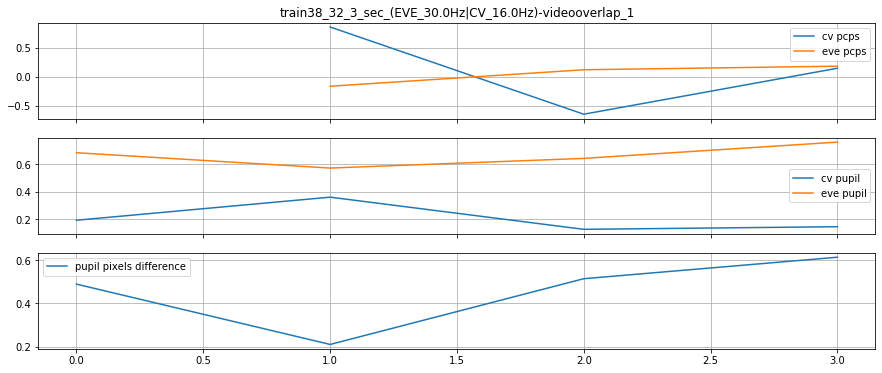

4 4
in terms of pcps

eve pcps mean| max| min: 0.04788664794001337 0.1838006230529594 -0.16251830161054182
cv mean| max| min: 0.12127762646238487 0.8608247422680411 -0.6454293628808865
cv sd 0.6152254878592257
eve sd 0.150877164937838
in terms of pupil radius
diff between two mean| max| min: 0.45675 0.613 0.211
diff sd 0.14926884303162533

eve mean| max| min: 0.66425 0.76 0.572
cv mean| max| min: 0.2075 0.361 0.128
cv sd 0.09182183836103477
eve sd 0.06805282874355778
4  SEC Timeframe
video length 10.0
3
video length 10.0
3


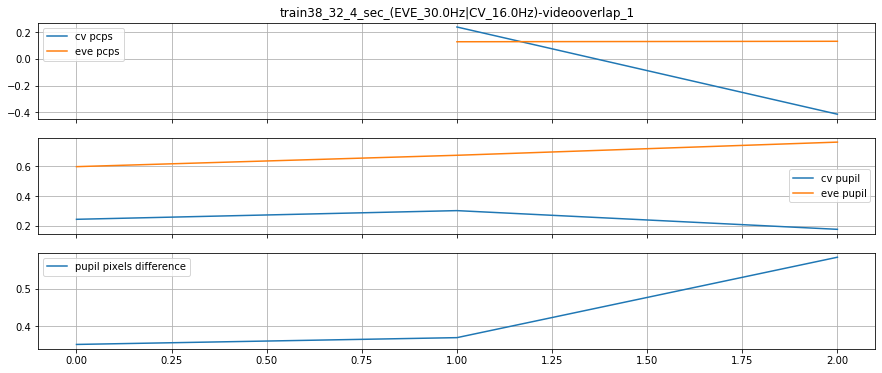

3 3
in terms of pcps

eve pcps mean| max| min: 0.1292345797379355 0.13095238095238093 0.12751677852349008
cv mean| max| min: -0.08810118336771255 0.23770491803278682 -0.4139072847682119
cv sd 0.32580610140049937
eve sd 0.0017178012144454247
in terms of pupil radius
diff between two mean| max| min: 0.435 0.583 0.352
diff sd 0.10490948479522715

eve mean| max| min: 0.676 0.76 0.596
cv mean| max| min: 0.24100000000000002 0.302 0.177
cv sd 0.051075108092559794
eve sd 0.06701243665668835


In [25]:
cv_38, s30_cv38, s31_cv38, s32_cv38 = input_data('train38')
run('30', s30_cv38, 'train38')
run('31', s31_cv38, 'train38')
run('32', s32_cv38, 'train38')

   step     ts      x     y     pupil  ratio   sim side    d2
0    30  133.0  154.0  33.5  5.333333   0.33  3.69    L -1.00
1    30  167.0  157.5  32.5  5.166667   0.32  4.64    L -1.00
2    30  600.0  164.0  40.0  7.000000   0.39  5.75    R -1.00
3    30  633.0  158.0  31.0  5.000000   0.31  5.69    L  8.06
4    30  667.0  161.0  38.0  5.666667   0.35  5.56    R -1.00 

      pupil     ts          x          y  validity
0  5.788193    0.0  39.612167  13.081570      True
1  5.758134   32.0  39.549995  12.852578      True
2  5.714533   68.0  39.683067  13.123153      True
3  5.679690  100.0  39.613255  13.227242      True
4  5.650708  132.0  39.757721  13.250206      True 

**medcouple 0.0
IQR 1.0 lower 3.83 Q1 5.333333333333333 Q3 6.333333333333333 upper 7.83
remove ratio  0.03 

**medcouple -0.2
IQR 9.5 lower -27.43 Q1 36.0 Q3 45.5 upper 59.65
remove ratio  0.03 

**medcouple 0.0
IQR 14.25 lower 111.25 Q1 154.0 Q3 168.25 upper 211.0
remove ratio  0.03 

** after clean cv data, remove 

C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


**medcouple 0.1
IQR 0.2730109691619873 lower 4.59 Q1 4.881289482116699 Q3 5.1543004512786865 upper 5.77
remove ratio  0.02 



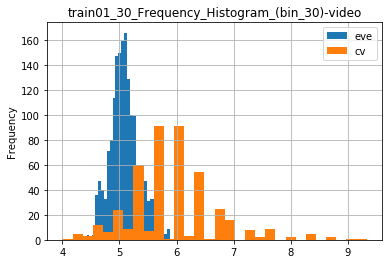

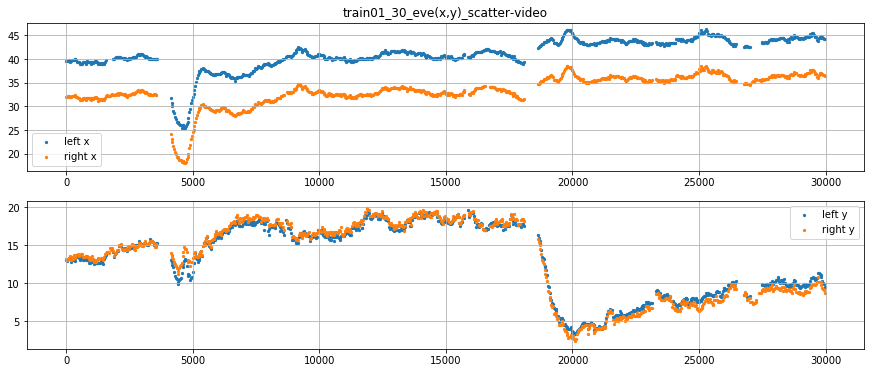

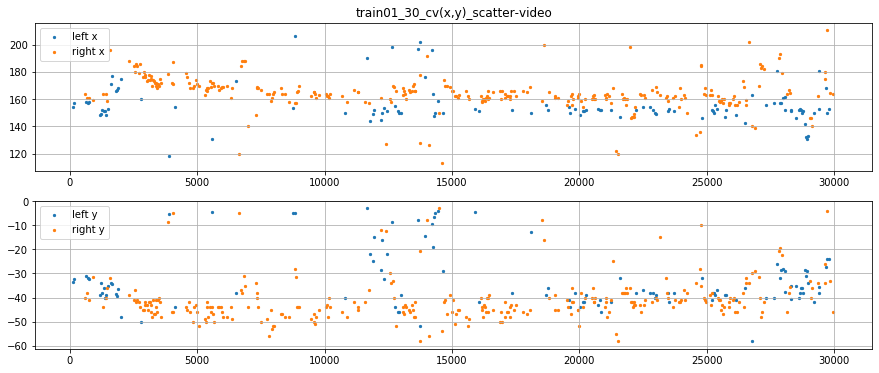

cv db
ts len 429
112
292
401

eve db
ts len 900
830
837
848
EVE 30.0 hz | CV 14.0 hz


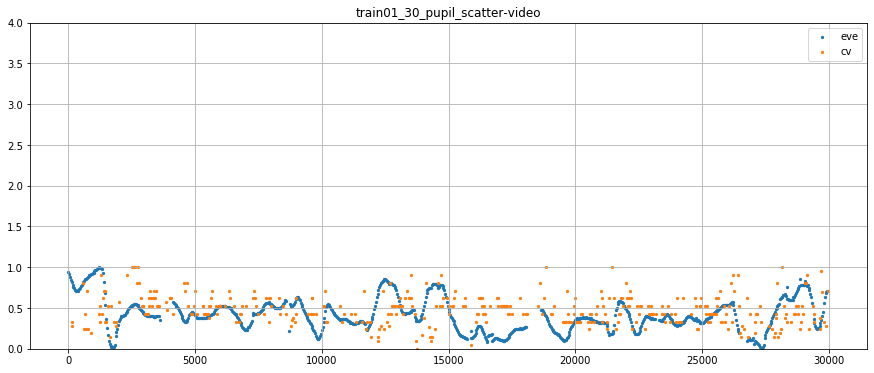

1  SEC Timeframe
video length 30.0
1
video length 30.0
1


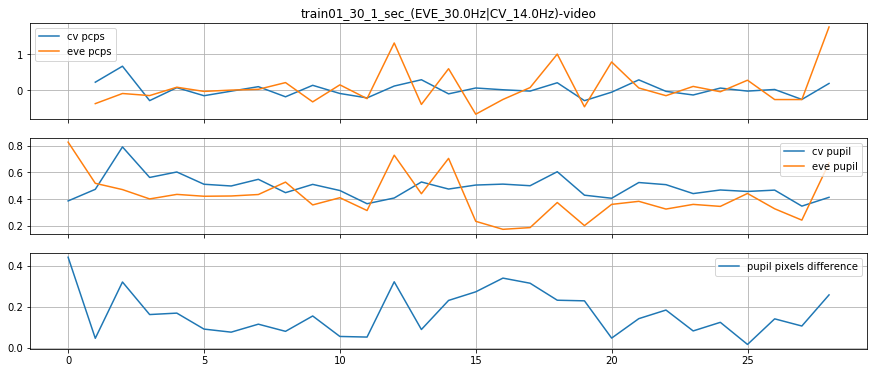

29 29
in terms of pcps

eve pcps mean| max| min: 0.10002436102500346 1.7685950413223144 -0.6695035460992907
cv mean| max| min: 0.021698252039045265 0.6723044397463003 -0.2909090909090909
cv sd 0.2048901811353353
eve sd 0.5397930332480657
in terms of pupil radius
diff between two mean| max| min: 0.16779310344827586 0.441 0.015
diff sd 0.10657209937985963

eve mean| max| min: 0.414896551724138 0.827 0.173
cv mean| max| min: 0.48800000000000004 0.791 0.347
cv sd 0.0845764294221097
eve sd 0.15638421845318293
2  SEC Timeframe
video length 30.0
2
video length 30.0
2


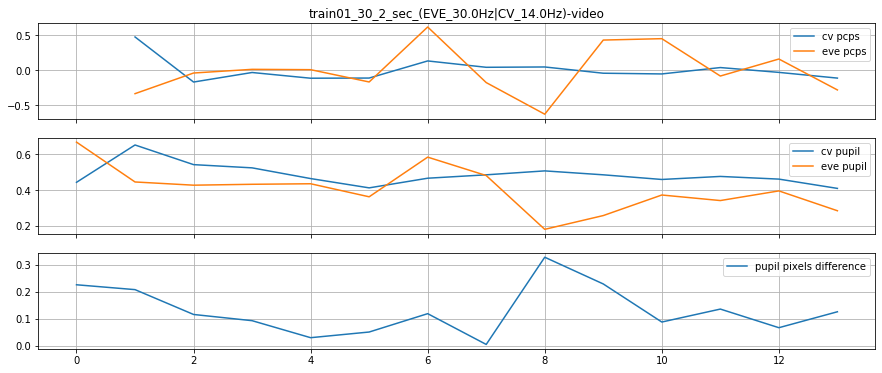

14 14
in terms of pcps

eve pcps mean| max| min: -0.0033133280657270904 0.6132596685082872 -0.6257796257796258
cv mean| max| min: 0.004324250611564342 0.47178329571106103 -0.16871165644171782
cv sd 0.15647986312724166
eve sd 0.3321599060381119
in terms of pupil radius
diff between two mean| max| min: 0.12914285714285714 0.327 0.004
diff sd 0.08604056945323373

eve mean| max| min: 0.40449999999999997 0.668 0.18
cv mean| max| min: 0.48464285714285715 0.652 0.409
cv sd 0.05864250913416838
eve sd 0.12100752633027183
3  SEC Timeframe
video length 30.0
2
video length 30.0
2


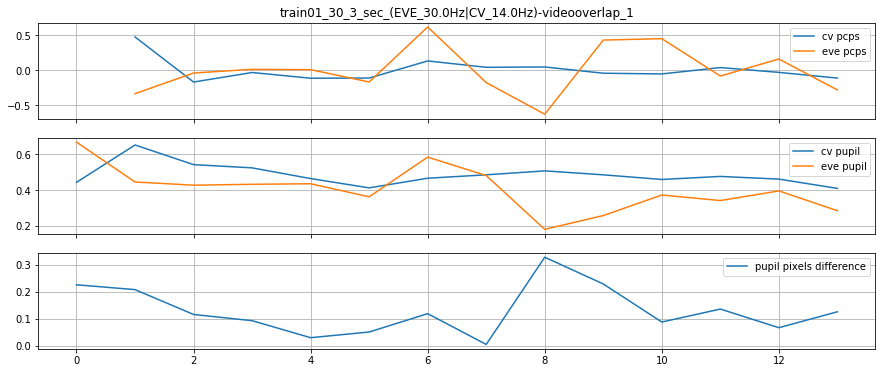

14 14
in terms of pcps

eve pcps mean| max| min: -0.0033133280657270904 0.6132596685082872 -0.6257796257796258
cv mean| max| min: 0.004324250611564342 0.47178329571106103 -0.16871165644171782
cv sd 0.15647986312724166
eve sd 0.3321599060381119
in terms of pupil radius
diff between two mean| max| min: 0.12914285714285714 0.327 0.004
diff sd 0.08604056945323373

eve mean| max| min: 0.40449999999999997 0.668 0.18
cv mean| max| min: 0.48464285714285715 0.652 0.409
cv sd 0.05864250913416838
eve sd 0.12100752633027183
4  SEC Timeframe
video length 30.0
3
video length 30.0
3


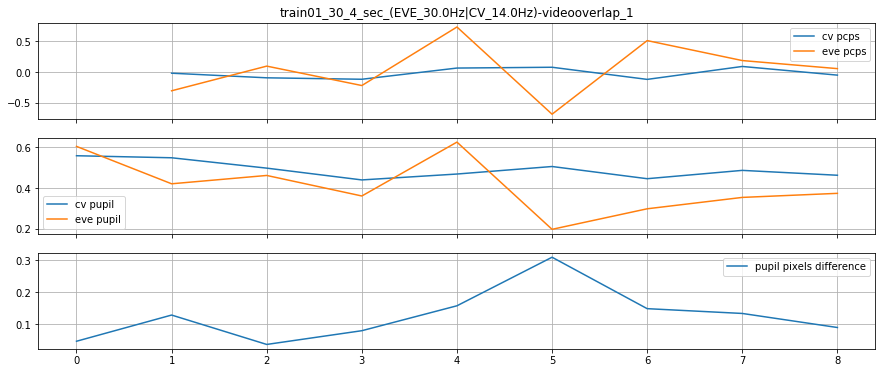

9 9
in terms of pcps

eve pcps mean| max| min: 0.047564465589888236 0.7340720221606649 -0.6853035143769968
cv mean| max| min: -0.01979761440187776 0.09192825112107617 -0.11857707509881421
cv sd 0.08282984418023477
eve sd 0.42448994985342886
in terms of pupil radius
diff between two mean| max| min: 0.125 0.309 0.036
diff sd 0.07677962692740249

eve mean| max| min: 0.41088888888888886 0.626 0.197
cv mean| max| min: 0.49077777777777776 0.559 0.44
cv sd 0.03968144760402043
eve sd 0.13006190358991407
      pupil     ts          x          y  validity
0  6.199445    0.0  43.580452  11.205662      True
1  6.189762   32.0  43.314545  11.071691      True
2  6.200444   68.0  43.371777  11.345180      True
3  6.208535  100.0  43.340996  11.434093      True
4  6.217939  132.0  43.395977  11.467850      True 

**medcouple 0.0
IQR 1.333333333333334 lower 3.33 Q1 5.333333333333333 Q3 6.666666666666667 upper 8.67
remove ratio  0.02 

**medcouple -0.2
IQR 34.0 lower -209.01 Q1 18.0 Q3 52.0 upper 102.65

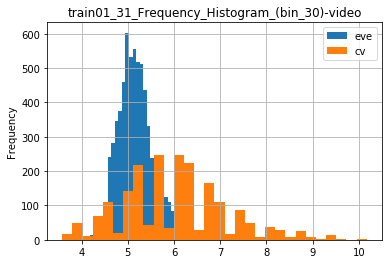

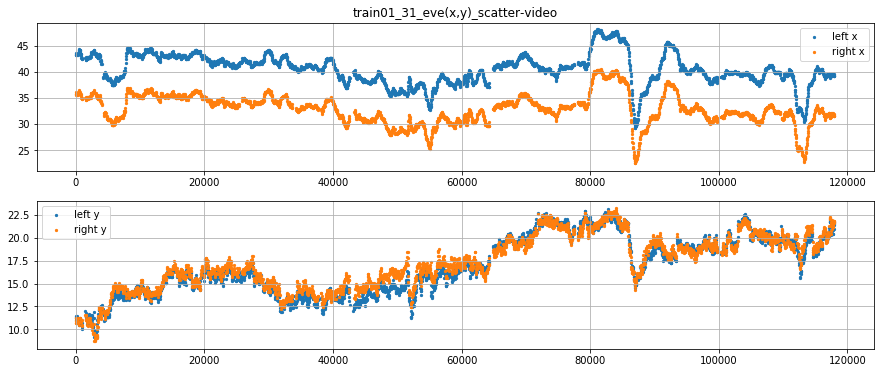

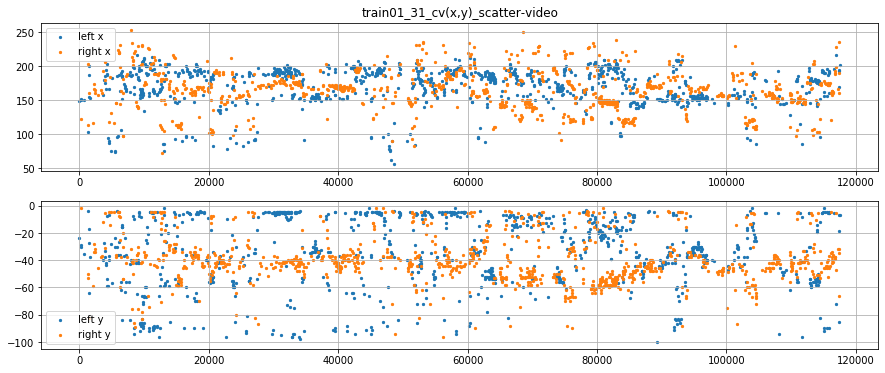

cv db
ts len 1814
991
995
1789

eve db
ts len 3540
3417
3351
3420
EVE 30.0 hz | CV 15.0 hz


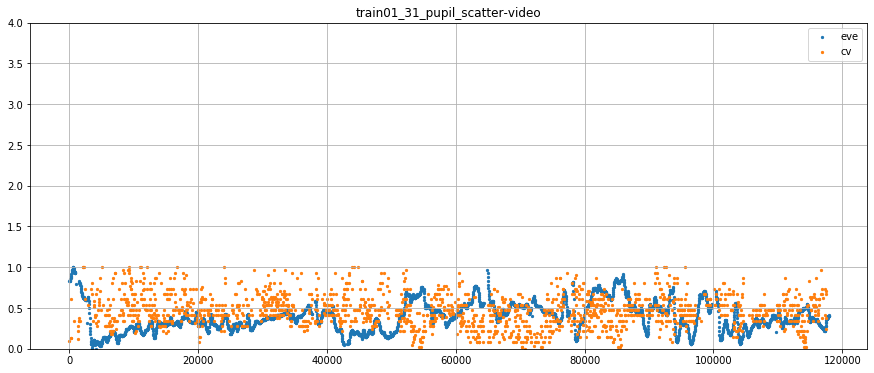

1  SEC Timeframe
video length 118.0
1
video length 118.0
1


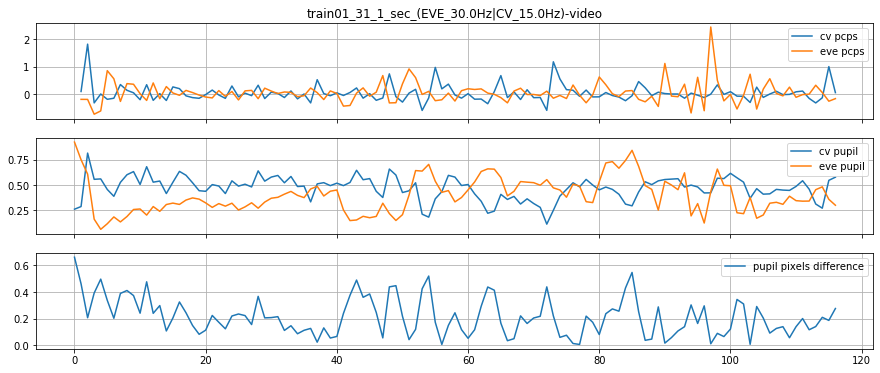

117 117
in terms of pcps

eve pcps mean| max| min: 0.05312334640616032 2.4523809523809526 -0.729818780889621
cv mean| max| min: 0.045259554847897746 1.8263888888888888 -0.5919540229885057
cv sd 0.3178892398848556
eve sd 0.38890856208319496
in terms of pupil radius
diff between two mean| max| min: 0.21306837606837606 0.66 0.007
diff sd 0.1390277428193065

eve mean| max| min: 0.3983162393162394 0.922 0.064
cv mean| max| min: 0.47111111111111115 0.814 0.115
cv sd 0.11284864515868168
eve sd 0.16880690681238925
2  SEC Timeframe
video length 118.0
2
video length 118.0
2


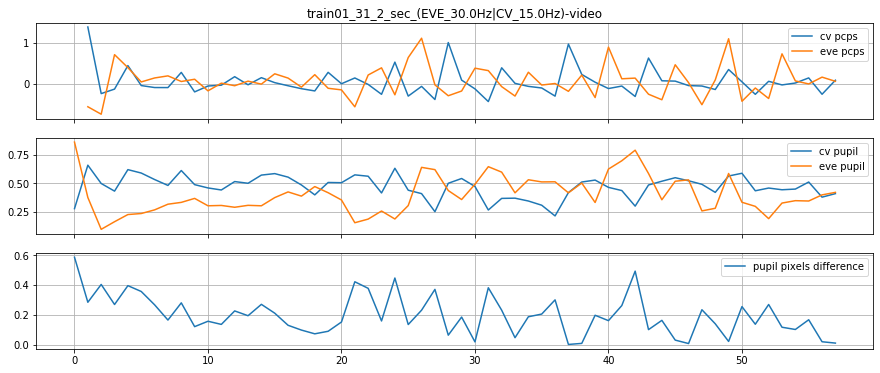

58 58
in terms of pcps

eve pcps mean| max| min: 0.057937475972058755 1.1052631578947367 -0.7466666666666666
cv mean| max| min: 0.04849172259660482 1.3790613718411553 -0.43855932203389825
cv sd 0.3308972309618872
eve sd 0.3783753102656183
in terms of pupil radius
diff between two mean| max| min: 0.1986206896551724 0.585 0.002
diff sd 0.13205586952266243

eve mean| max| min: 0.39891379310344827 0.862 0.095
cv mean| max| min: 0.46974137931034476 0.659 0.213
cv sd 0.0973976138532377
eve sd 0.1591923889710247
3  SEC Timeframe
video length 118.0
2
video length 118.0
2


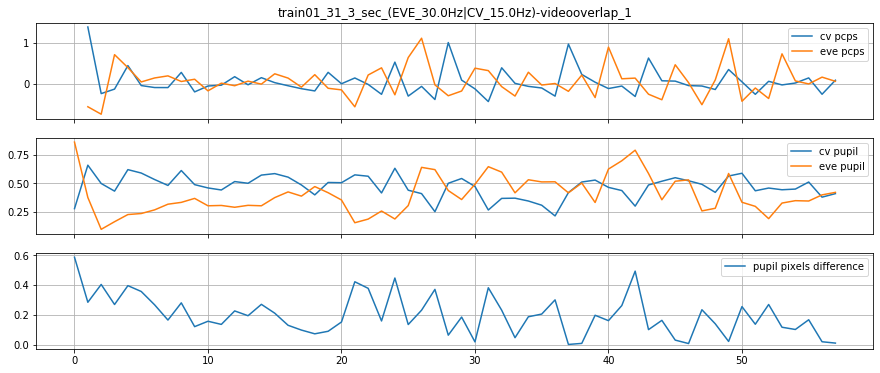

58 58
in terms of pcps

eve pcps mean| max| min: 0.057937475972058755 1.1052631578947367 -0.7466666666666666
cv mean| max| min: 0.04849172259660482 1.3790613718411553 -0.43855932203389825
cv sd 0.3308972309618872
eve sd 0.3783753102656183
in terms of pupil radius
diff between two mean| max| min: 0.1986206896551724 0.585 0.002
diff sd 0.13205586952266243

eve mean| max| min: 0.39891379310344827 0.862 0.095
cv mean| max| min: 0.46974137931034476 0.659 0.213
cv sd 0.0973976138532377
eve sd 0.1591923889710247
4  SEC Timeframe
video length 118.0
3
video length 118.0
3


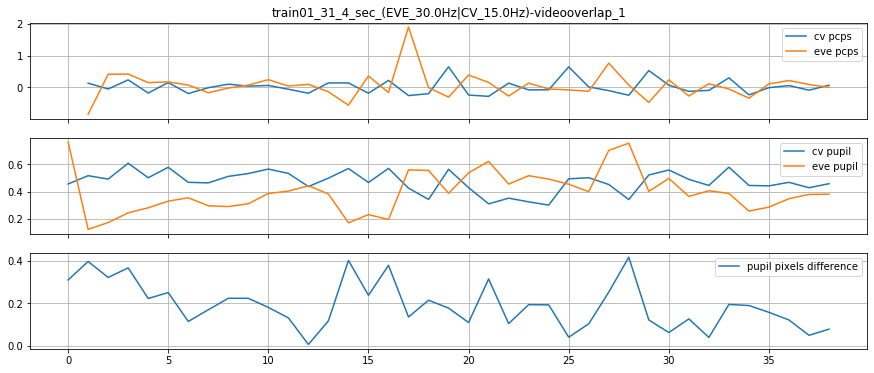

39 39
in terms of pcps

eve pcps mean| max| min: 0.0639296345233588 1.9015544041450778 -0.8418300653594771
cv mean| max| min: 0.022904891788456765 0.6491228070175437 -0.2797202797202797
cv sd 0.22794466158983284
eve sd 0.4195901479100344
in terms of pupil radius
diff between two mean| max| min: 0.1904615384615385 0.416 0.006
diff sd 0.10706141208020514

eve mean| max| min: 0.3975897435897436 0.765 0.121
cv mean| max| min: 0.4729743589743589 0.609 0.3
cv sd 0.07858605839019434
eve sd 0.15053813179914013
      pupil     ts          x          y  validity
0  7.087145    0.0  44.391479  17.354094      True
1  7.073361   36.0  44.860168  17.267088      True
2  7.061670   68.0  44.478142  17.342180      True
3  7.047737  100.0  44.748741  17.157587      True
4  7.027136  136.0  44.336281  17.344528      True 

**medcouple 0.0
IQR 1.166666666666666 lower 3.92 Q1 5.666666666666667 Q3 6.833333333333333 upper 8.58
remove ratio  0.04 

**medcouple 0.0
IQR 12.0 lower 0.0 Q1 36.0 Q3 48.0 upper 84.0

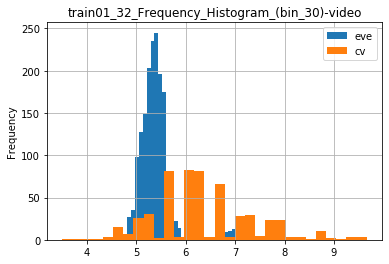

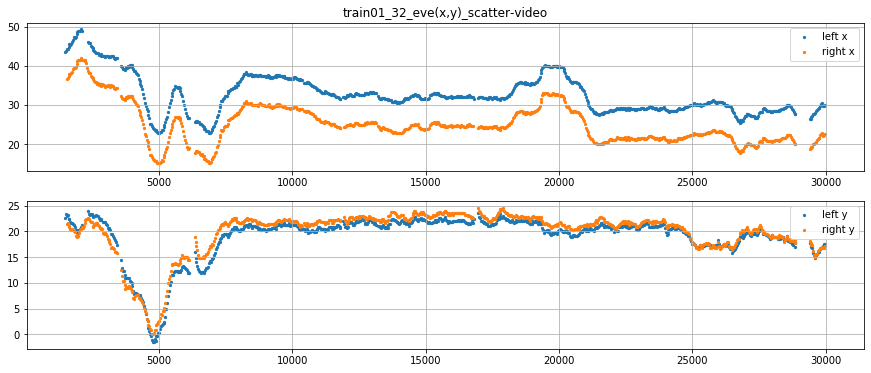

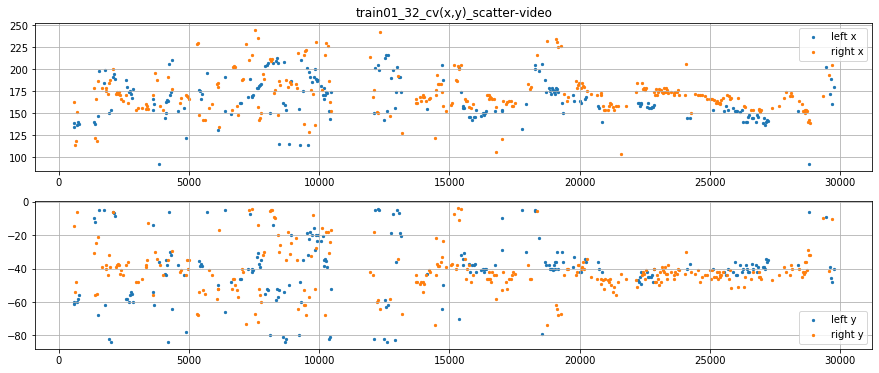

cv db
ts len 494
215
292
470

eve db
ts len 900
815
819
823
EVE 30.0 hz | CV 16.0 hz


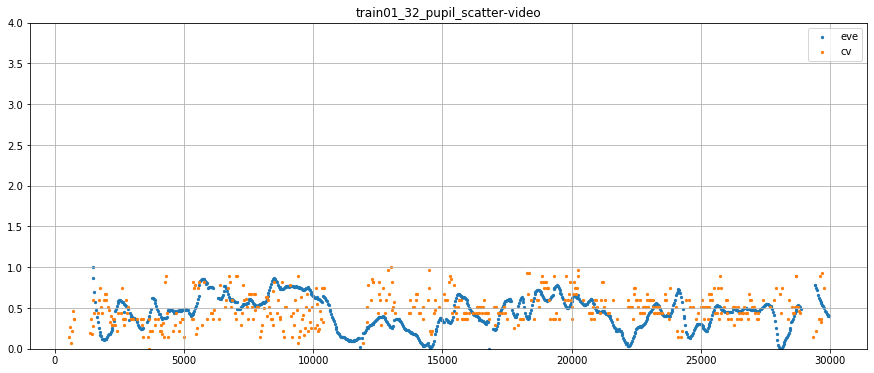

1  SEC Timeframe
video length 30.0
1
video length 30.0
1


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


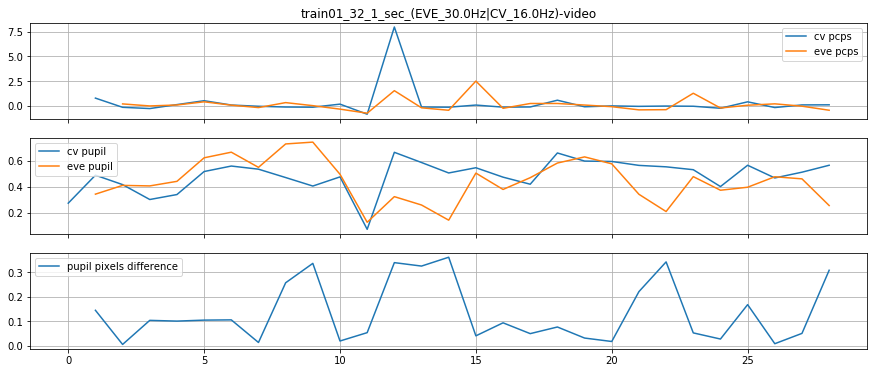

29 29
in terms of pcps

eve pcps mean| max| min: 0.12993057161954033 2.5000000000000004 -0.7414141414141414
cv mean| max| min: 0.2928563628914094 7.95945945945946 -0.8442105263157895
cv sd 1.5048557622175645
eve sd 0.6610823306740625
in terms of pupil radius
diff between two mean| max| min: 0.1344642857142857 0.361 0.006
diff sd 0.12054444412831346

eve mean| max| min: 0.44207142857142856 0.741 0.128
cv mean| max| min: 0.4841724137931034 0.663 0.074
cv sd 0.12110926071983363
eve sd 0.15819471017240308
2  SEC Timeframe
video length 30.0
2
video length 30.0
2


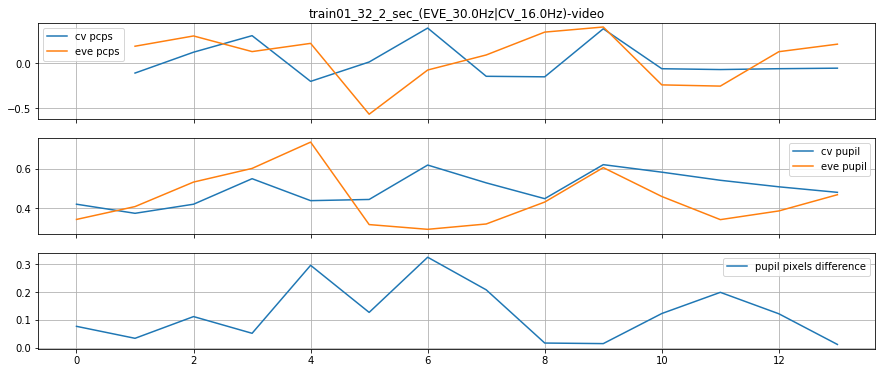

14 14
in terms of pcps

eve pcps mean| max| min: 0.06832282718424794 0.40371229698375877 -0.5681198910081744
cv mean| max| min: 0.02791903552874248 0.3918918918918919 -0.2021857923497269
cv sd 0.19865260880484287
eve sd 0.2686966776916029
in terms of pupil radius
diff between two mean| max| min: 0.12278571428571428 0.325 0.012
diff sd 0.09789584740312282

eve mean| max| min: 0.44564285714285706 0.734 0.293
cv mean| max| min: 0.4978571428571429 0.62 0.374
cv sd 0.07496366466767858
eve sd 0.12618501560512366
3  SEC Timeframe
video length 30.0
2
video length 30.0
2


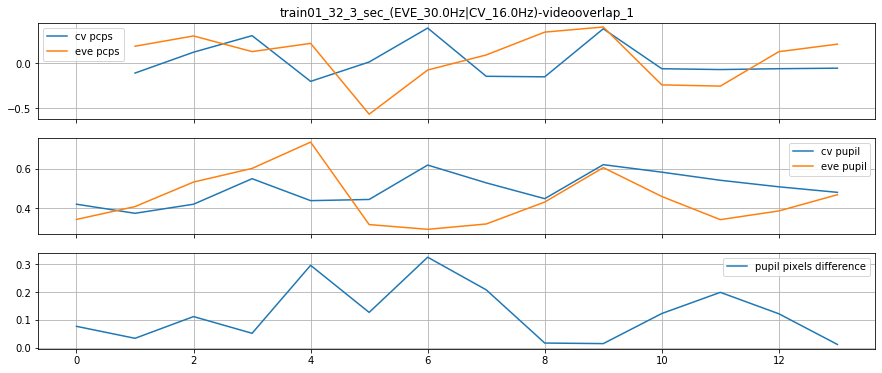

14 14
in terms of pcps

eve pcps mean| max| min: 0.06832282718424794 0.40371229698375877 -0.5681198910081744
cv mean| max| min: 0.02791903552874248 0.3918918918918919 -0.2021857923497269
cv sd 0.19865260880484287
eve sd 0.2686966776916029
in terms of pupil radius
diff between two mean| max| min: 0.12278571428571428 0.325 0.012
diff sd 0.09789584740312282

eve mean| max| min: 0.44564285714285706 0.734 0.293
cv mean| max| min: 0.4978571428571429 0.62 0.374
cv sd 0.07496366466767858
eve sd 0.12618501560512366
4  SEC Timeframe
video length 30.0
3
video length 30.0
3


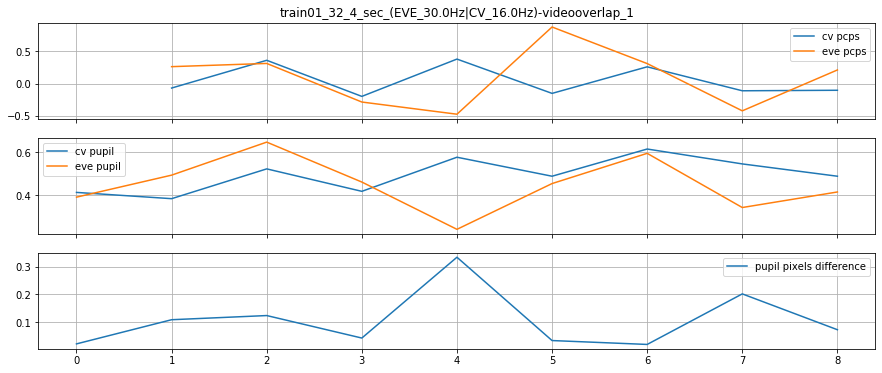

9 9
in terms of pcps

eve pcps mean| max| min: 0.09719168738827921 0.8724279835390947 -0.474025974025974
cv mean| max| min: 0.04439922116603198 0.3770883054892602 -0.1988527724665392
cv sd 0.2270722275466071
eve sd 0.42896520913792824
in terms of pupil radius
diff between two mean| max| min: 0.10677777777777776 0.334 0.02
diff sd 0.0978783573600731

eve mean| max| min: 0.4497777777777778 0.647 0.243
cv mean| max| min: 0.49522222222222223 0.615 0.385
cv sd 0.07379969553953726
eve sd 0.11573127665009891


In [26]:
cv_1, s30_cv1, s31_cv1, s32_cv1 = input_data('train01')
run('30', s30_cv1, 'train01')
run('31', s31_cv1, 'train01')
run('32', s32_cv1, 'train01')

   step     ts      x     y     pupil  ratio   sim side   d2
0    30   33.0  154.0  45.0  5.000000   0.31  2.93    R -1.0
1    30  133.0  155.0  43.5  5.083333   0.32  3.16    R -1.0
2    30  267.0  150.0  45.5  4.916667   0.31  2.22    R -1.0
3    30  800.0  155.0  38.5  5.083333   0.32  2.39    L -1.0
4    30  900.0  153.0  43.5  4.916667   0.31  2.65    R -1.0 

      pupil     ts          x         y  validity
0  5.483619    0.0  18.264683 -0.471290      True
1  5.458597   32.0  18.216194  0.405570      True
2  5.449193   68.0  17.805439  0.767192      True
3  5.448682  100.0  17.557562  0.939736      True
4  5.452895  132.0  17.579275  0.755937      True 

**medcouple 0.4
IQR 1.25 lower 4.29 Q1 4.75 Q3 6.0 upper 15.29
remove ratio  0.01 

**medcouple 0.2
IQR 12.25 lower 20.5 Q1 38.75 Q3 51.0 upper 132.79
remove ratio  0.01 

**medcouple 0.3
IQR 27.0 lower 118.16 Q1 146.5 Q3 173.5 upper 442.43
remove ratio  0.01 

** after clean cv data, remove ratio 0.02409638554216864 

**medcoup

C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


IQR 0.4768218994140625 lower 4.01 Q1 4.7300238609313965 Q3 5.206845760345459 upper 5.92
remove ratio  0.0 

**medcouple -0.0
IQR 0.470217227935791 lower 3.82 Q1 4.528852939605713 Q3 4.999070167541504 upper 5.7
remove ratio  0.0 



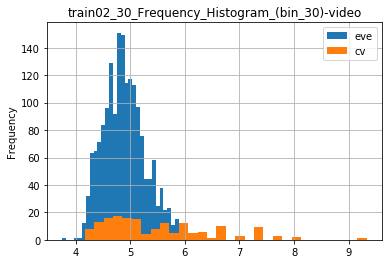

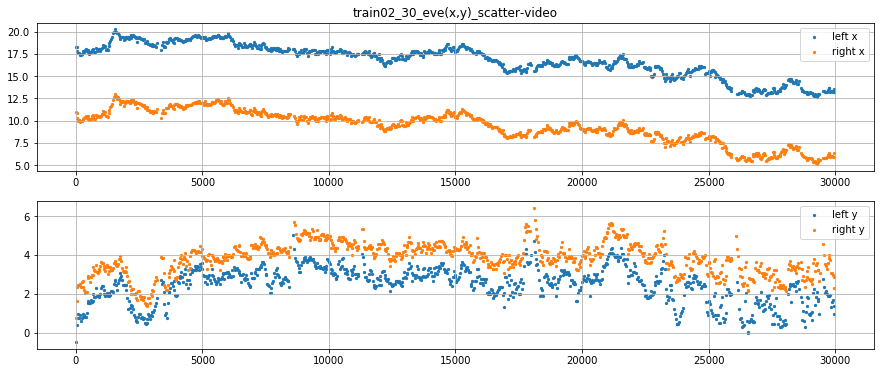

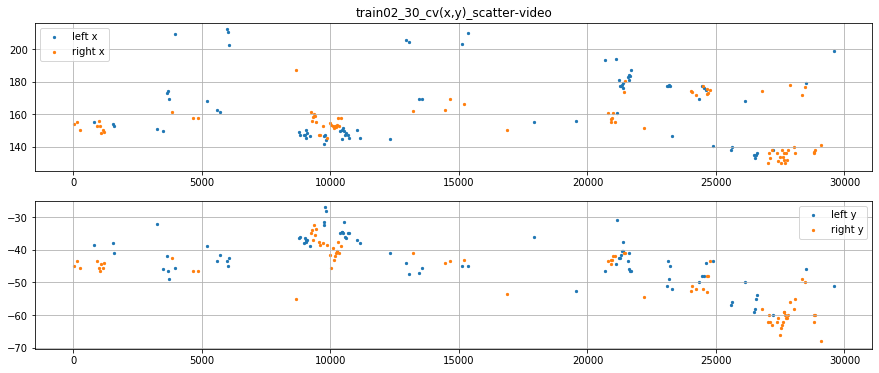

cv db
ts len 165
81
81
162

eve db
ts len 900
871
872
874
EVE 30.0 hz | CV 6.0 hz


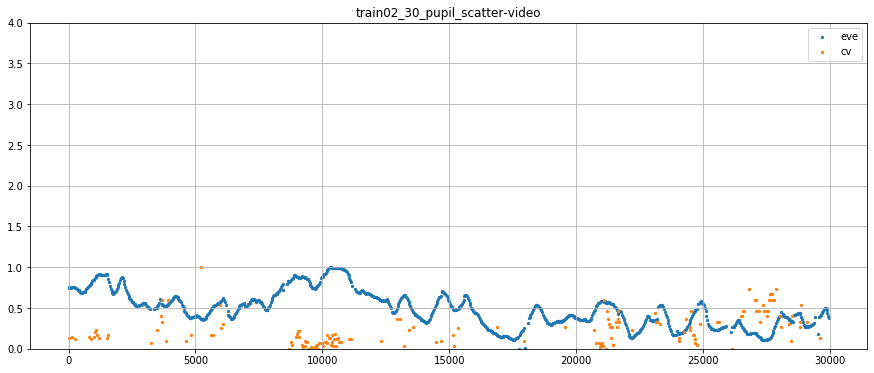

1  SEC Timeframe
video length 30.0
1
video length 30.0
1


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


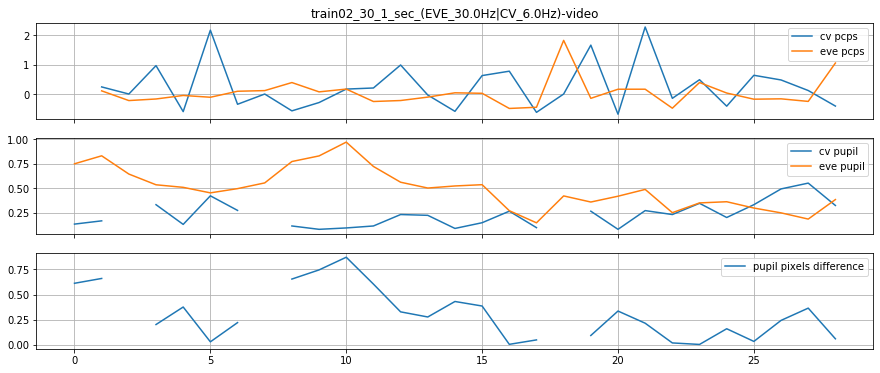

29 29
in terms of pcps

eve pcps mean| max| min: 0.04883772958963841 1.8322147651006713 -0.4925373134328358
cv mean| max| min: 0.2546721816279349 2.289156626506024 -0.6891385767790262
cv sd 0.7883011551545277
eve sd 0.4585457012439338
in terms of pupil radius
diff between two mean| max| min: 0.3069230769230769 0.871 0.004
diff sd 0.2489431388701696

eve mean| max| min: 0.4956896551724138 0.968 0.149
cv mean| max| min: 0.2330384615384616 0.552 0.083
cv sd 0.12587126536182505
eve sd 0.20128656933941919
2  SEC Timeframe
video length 30.0
2
video length 30.0
2


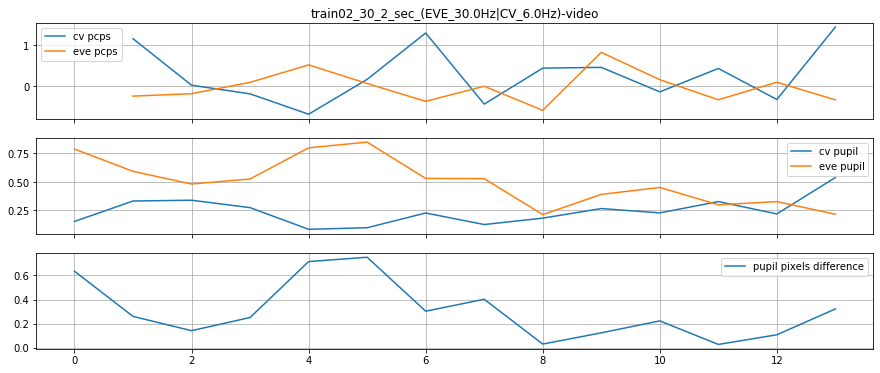

14 14
in terms of pcps

eve pcps mean| max| min: -0.025677628949969354 0.8271028037383179 -0.5954631379962193
cv mean| max| min: 0.2797470882196756 1.4500000000000002 -0.6909090909090909
cv sd 0.6558882254787171
eve sd 0.3730302602960953
in terms of pupil radius
diff between two mean| max| min: 0.30657142857142855 0.75 0.028
diff sd 0.23065487956986247

eve mean| max| min: 0.49992857142857144 0.849 0.214
cv mean| max| min: 0.24335714285714286 0.539 0.085
cv sd 0.11513197839427408
eve sd 0.19843151545692184
3  SEC Timeframe
video length 30.0
2
video length 30.0
2


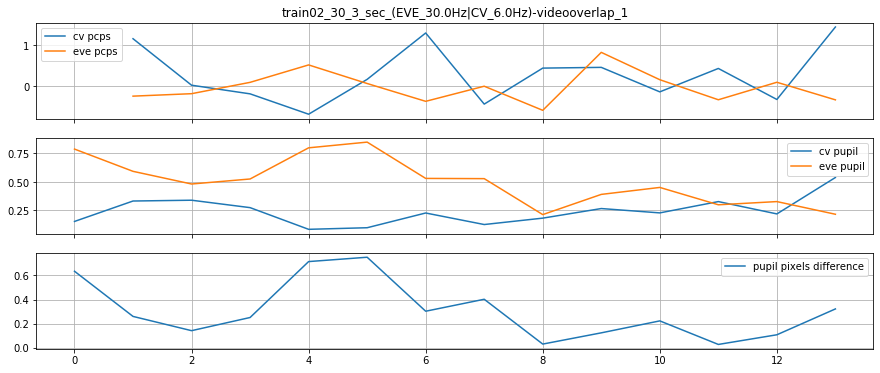

14 14
in terms of pcps

eve pcps mean| max| min: -0.025677628949969354 0.8271028037383179 -0.5954631379962193
cv mean| max| min: 0.2797470882196756 1.4500000000000002 -0.6909090909090909
cv sd 0.6558882254787171
eve sd 0.3730302602960953
in terms of pupil radius
diff between two mean| max| min: 0.30657142857142855 0.75 0.028
diff sd 0.23065487956986247

eve mean| max| min: 0.49992857142857144 0.849 0.214
cv mean| max| min: 0.24335714285714286 0.539 0.085
cv sd 0.11513197839427408
eve sd 0.19843151545692184
4  SEC Timeframe
video length 30.0
3
video length 30.0
3


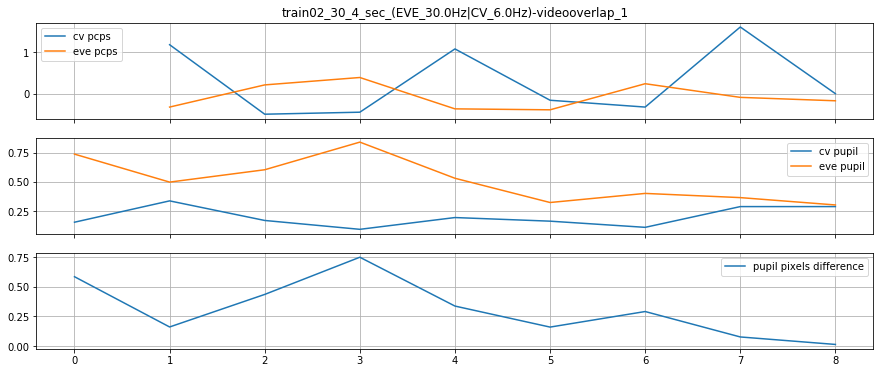

9 9
in terms of pcps

eve pcps mean| max| min: -0.06264781498203713 0.39238410596026485 -0.391713747645951
cv mean| max| min: 0.3074184200896401 1.6181818181818182 -0.49851632047477745
cv sd 0.7934105346821998
eve sd 0.2870342222401868
in terms of pupil radius
diff between two mean| max| min: 0.3118888888888889 0.748 0.014
diff sd 0.22857259699877724

eve mean| max| min: 0.5114444444444444 0.841 0.302
cv mean| max| min: 0.19955555555555557 0.337 0.093
cv sd 0.0804751322681749
eve sd 0.17703929953613945
      pupil     ts          x         y  validity
0  5.050899    0.0  14.361618  2.718889      True
1  5.020789   32.0  14.415800  2.718532      True
2  4.988530   68.0  14.364683  2.540076      True
3  4.968571  100.0  14.058049  3.038398      True
4  4.944470  132.0  14.206363  2.929407      True 

**medcouple 0.0
IQR 0.3333333333333339 lower 4.83 Q1 5.333333333333333 Q3 5.666666666666667 upper 6.17
remove ratio  0.16 

**medcouple -0.2
IQR 8.5 lower -12.75 Q1 44.0 Q3 52.5 upper 65.16


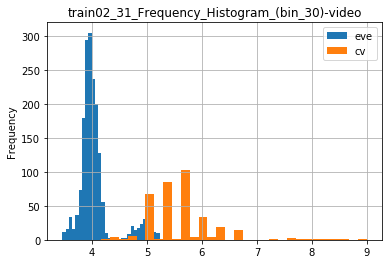

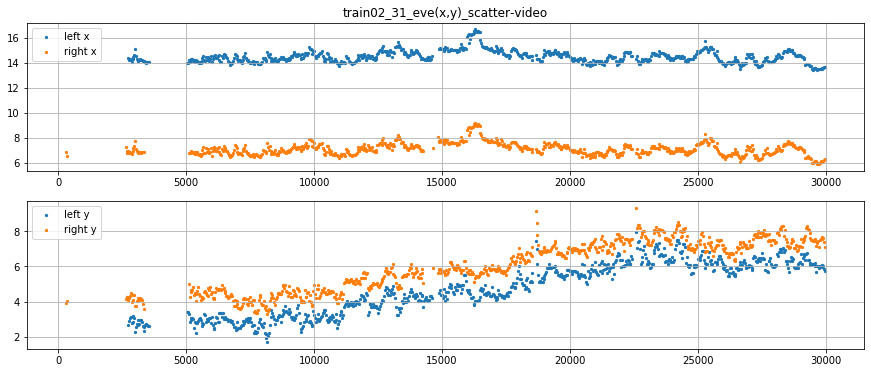

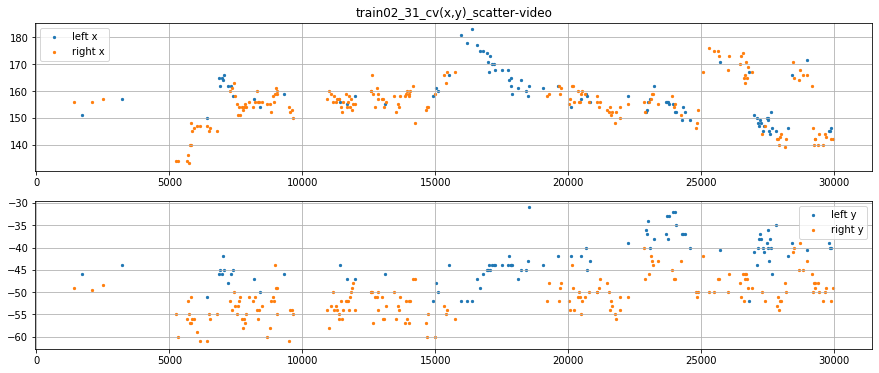

cv db
ts len 353
94
195
289

eve db
ts len 900
757
748
766
EVE 30.0 hz | CV 12.0 hz


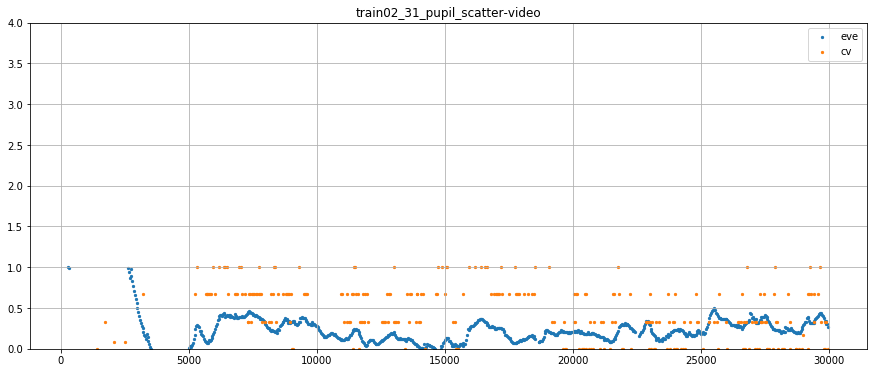

1  SEC Timeframe
video length 30.0
1
video length 30.0
1


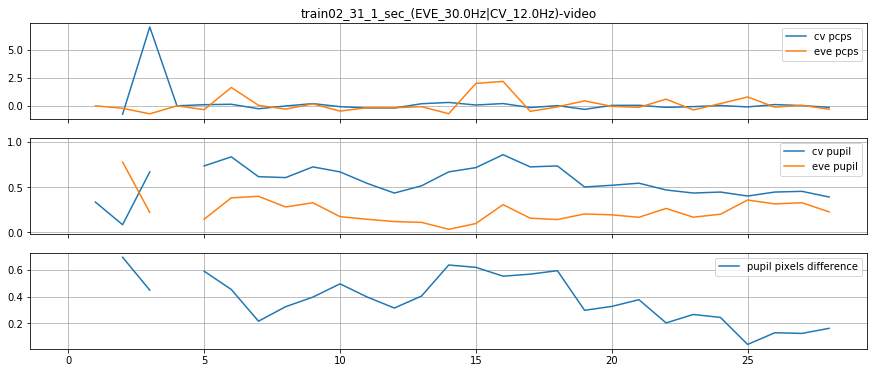

29 29
in terms of pcps

eve pcps mean| max| min: 0.11929389175705671 2.177083333333333 -0.7177835051546392
cv mean| max| min: 0.22421570277727604 7.0361445783132535 -0.7507507507507507
cv sd 1.3512197800919412
eve sd 0.7158116466646713
in terms of pupil radius
diff between two mean| max| min: 0.37999999999999995 0.693 0.044
diff sd 0.17419485111175403

eve mean| max| min: 0.26644444444444443 0.996 0.032
cv mean| max| min: 0.5564814814814816 0.857 0.083
cv sd 0.16769248097509618
eve sd 0.19979310286047733
2  SEC Timeframe
video length 30.0
2
video length 30.0
2


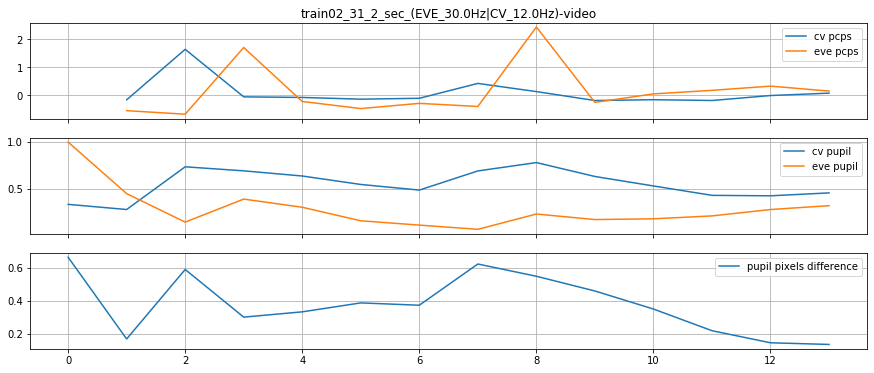

14 14
in terms of pcps

eve pcps mean| max| min: 0.14973144549271922 2.4328358208955225 -0.6778523489932886
cv mean| max| min: 0.08869176993985645 1.636690647482014 -0.19023136246786632
cv sd 0.47575763745466937
eve sd 0.8785228648787532
in terms of pupil radius
diff between two mean| max| min: 0.3782142857142857 0.663 0.136
diff sd 0.17132599609742682

eve mean| max| min: 0.28585714285714287 0.996 0.067
cv mean| max| min: 0.5452142857142858 0.778 0.278
cv sd 0.14711617303120325
eve sd 0.22206976289408864
3  SEC Timeframe
video length 30.0
2
video length 30.0
2


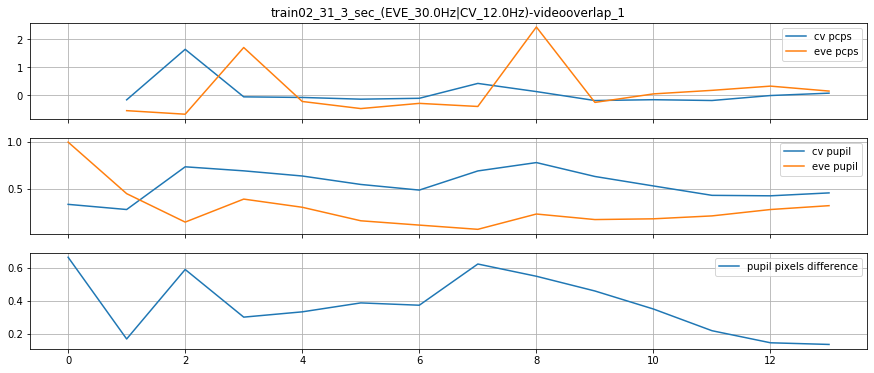

14 14
in terms of pcps

eve pcps mean| max| min: 0.14973144549271922 2.4328358208955225 -0.6778523489932886
cv mean| max| min: 0.08869176993985645 1.636690647482014 -0.19023136246786632
cv sd 0.47575763745466937
eve sd 0.8785228648787532
in terms of pupil radius
diff between two mean| max| min: 0.3782142857142857 0.663 0.136
diff sd 0.17132599609742682

eve mean| max| min: 0.28585714285714287 0.996 0.067
cv mean| max| min: 0.5452142857142858 0.778 0.278
cv sd 0.14711617303120325
eve sd 0.22206976289408864
4  SEC Timeframe
video length 30.0
3
video length 30.0
3


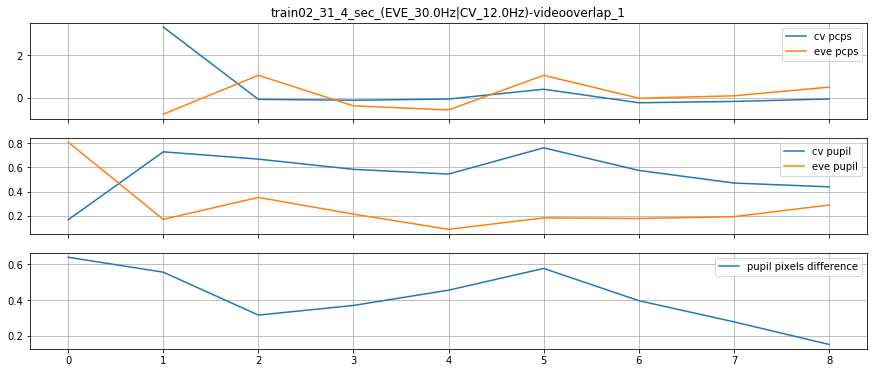

9 9
in terms of pcps

eve pcps mean| max| min: 0.11309427489022246 1.0584795321637426 -0.7881040892193308
cv mean| max| min: 0.37288874117842624 3.3532934131736525 -0.24473684210526325
cv sd 1.1409472595484644
eve sd 0.6618941326420803
in terms of pupil radius
diff between two mean| max| min: 0.415 0.64 0.15
diff sd 0.14910697129540554

eve mean| max| min: 0.27511111111111114 0.807 0.089
cv mean| max| min: 0.5478888888888889 0.76 0.167
cv sd 0.16871701781019435
eve sd 0.20079809895317702
      pupil     ts          x         y  validity
0  4.863462    0.0  15.749273  5.450972      True
1  4.880356   36.0  15.208241  5.812404      True
2  4.902359   68.0  15.579711  5.455501      True
3  4.929037  100.0  15.638695  5.871687      True
4  4.948686  136.0  15.692662  5.472661      True 

**medcouple 0.0
IQR 1.5 lower 2.25 Q1 4.5 Q3 6.0 upper 8.25
remove ratio  0.0 

**medcouple 0.2
IQR 10.25 lower 24.48 Q1 39.75 Q3 50.0 upper 118.44
remove ratio  0.0 

**medcouple -0.0
IQR 36.25 lower 27.2

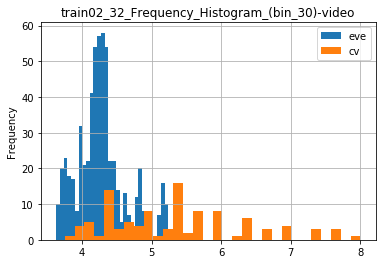

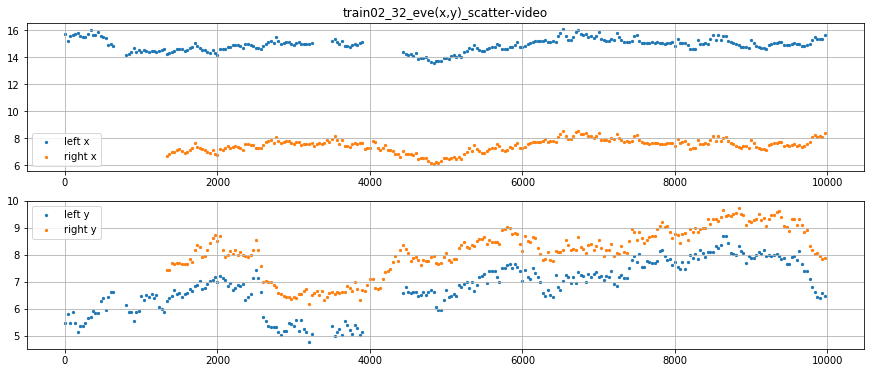

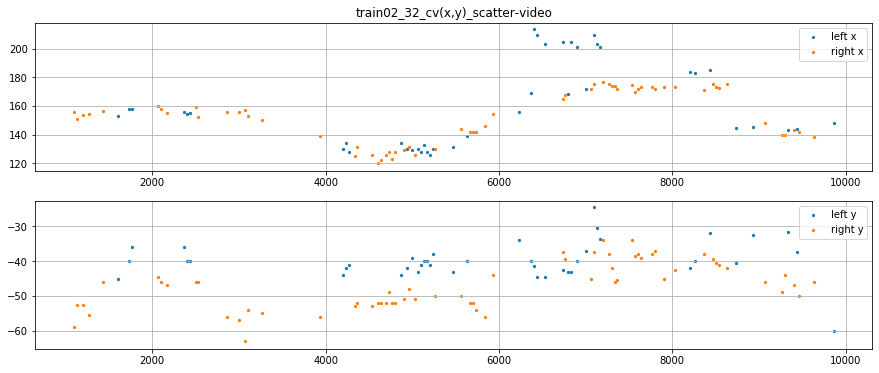

cv db
ts len 102
41
63
102

eve db
ts len 300
274
260
296
EVE 30.0 hz | CV 10.0 hz


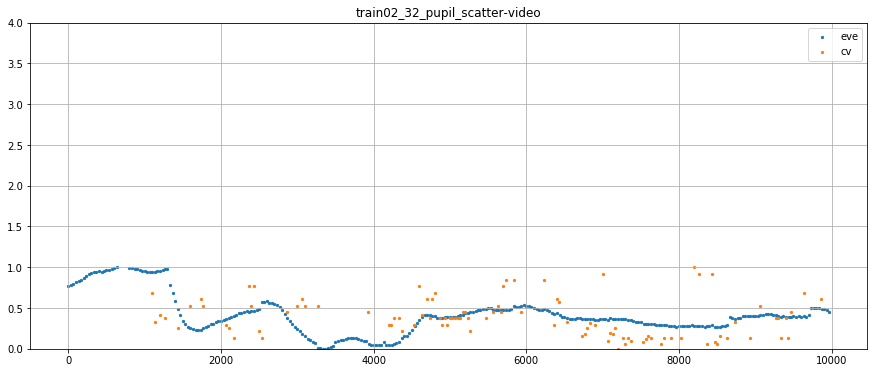

1  SEC Timeframe
video length 10.0
1
video length 10.0
1


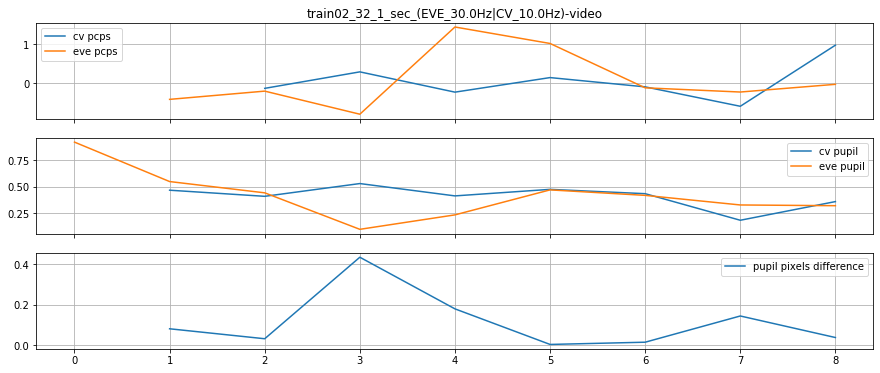

9 9
in terms of pcps

eve pcps mean| max| min: 0.09095113600202608 1.4421052631578948 -0.7845804988662132
cv mean| max| min: 0.05869072019290452 0.9779005524861879 -0.581986143187067
cv sd 0.4556587210913109
eve sd 0.7013977229844041
in terms of pupil radius
diff between two mean| max| min: 0.11674999999999999 0.434 0.005
diff sd 0.13339391852704532

eve mean| max| min: 0.4187777777777778 0.922 0.095
cv mean| max| min: 0.407625 0.529 0.181
cv sd 0.09812611464335068
eve sd 0.21889407777267667
2  SEC Timeframe
video length 10.0
2
video length 10.0
2


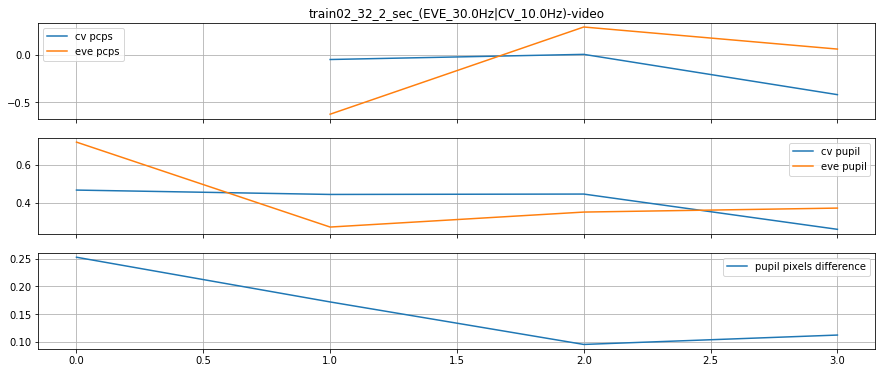

4 4
in terms of pcps

eve pcps mean| max| min: -0.09052490218921665 0.2915129151291511 -0.6230876216968011
cv mean| max| min: -0.1542730261932077 0.004514672686230181 -0.41797752808988764
cv sd 0.18775971629662017
eve sd 0.3882583719851897
in terms of pupil radius
diff between two mean| max| min: 0.158 0.253 0.095
diff sd 0.06185870997684966

eve mean| max| min: 0.42774999999999996 0.719 0.271
cv mean| max| min: 0.40325 0.466 0.259
cv sd 0.08376865463883254
eve sd 0.17223729996722545
3  SEC Timeframe
video length 10.0
2
video length 10.0
2


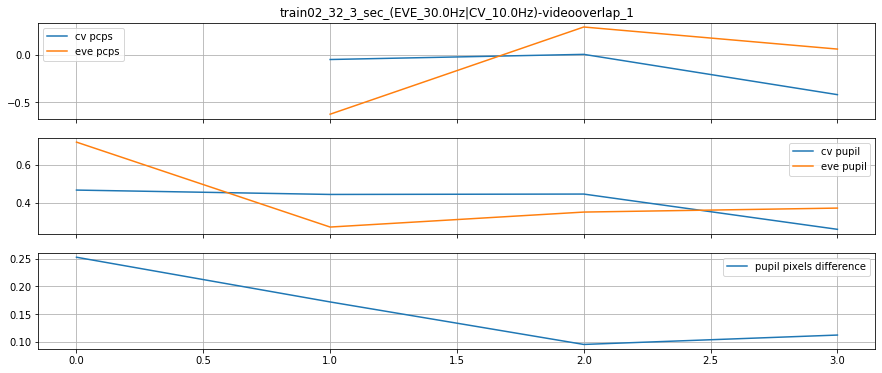

4 4
in terms of pcps

eve pcps mean| max| min: -0.09052490218921665 0.2915129151291511 -0.6230876216968011
cv mean| max| min: -0.1542730261932077 0.004514672686230181 -0.41797752808988764
cv sd 0.18775971629662017
eve sd 0.3882583719851897
in terms of pupil radius
diff between two mean| max| min: 0.158 0.253 0.095
diff sd 0.06185870997684966

eve mean| max| min: 0.42774999999999996 0.719 0.271
cv mean| max| min: 0.40325 0.466 0.259
cv sd 0.08376865463883254
eve sd 0.17223729996722545
4  SEC Timeframe
video length 10.0
3
video length 10.0
3


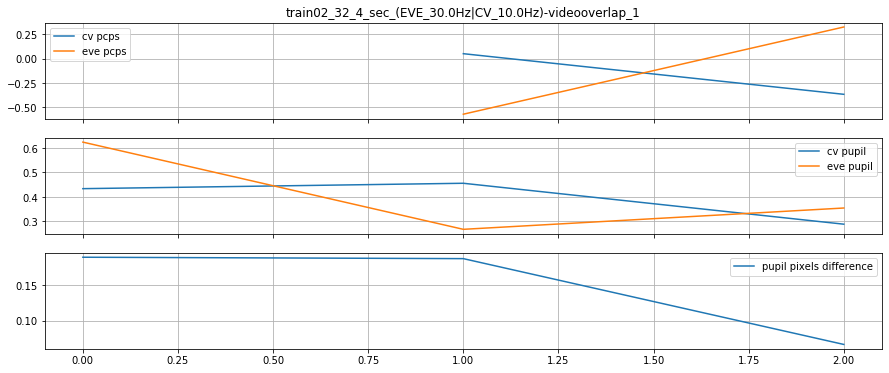

3 3
in terms of pcps

eve pcps mean| max| min: -0.12294297742058946 0.32462686567164156 -0.5705128205128205
cv mean| max| min: -0.15776841296790362 0.05069124423963145 -0.3662280701754387
cv sd 0.20845965720753507
eve sd 0.447569843092231
in terms of pupil radius
diff between two mean| max| min: 0.148 0.19 0.066
diff sd 0.05798850460795369

eve mean| max| min: 0.41566666666666663 0.624 0.268
cv mean| max| min: 0.393 0.456 0.289
cv sd 0.07408553615022752
eve sd 0.15153510777667625


In [27]:
cv_2, s30_cv2, s31_cv2, s32_cv2  = input_data('train02')
run('30', s30_cv2, 'train02')
run('31', s31_cv2, 'train02')
run('32', s32_cv2, 'train02')